# Analysis of Bike Rentals and study of ML algorythms performance

## Introduction and data description

In this study we will conduct exploratory analysis of bicycle rentals in Washington D.C. in 2011-2012. Afterwards, we will explore the performance of several ML algorythms for prediction of the number of hourly rentals. The algorythms, wchich we will use are linear regression ,decision tree and random forest. We will also utilize k-means clustering algorythm for grouping the weather parameters.

The dataset was pulled from the [UCI website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). It contains information on hourly bike rentals, weather parameters and some datetime features. It was combined by Hadi Fanaee-T for his research article [Event labeling combining ensemble detectors and background knowledge](https://link.springer.com/article/10.1007/s13748-013-0040-3), which was done in collaboration with Joao Gama. 

The data set was obtained by combining the information about bike rentals in Washington D.C. from [Capital Bikeshare](https://www.capitalbikeshare.com/system-data) with [weather parameters](http://www.freemeteo.com) and [holiday schedule](http://dchr.dc.gov/page/holiday-schedule). All the logs are aggregated on an hourly level.

Data fields:

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit :
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

## Preliminary data exploration

Before we start with analysis of bike rentals, we need to understand some specifics of the data and do data cleaning if needed. As the dataset was used for research, it should be already cleaned. However, we might still encounter some pecularities, which we should take into account in our analysis.

First, let's load all libraries and read in the data:

In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
%matplotlib inline
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from itertools import combinations

df_raw = pd.read_csv("bike_rental_hour.csv", parse_dates = ["dteday"])
df_raw.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [2]:
print("Number of rows: {}\nNumber of columns: {}".format(*df_raw.shape))

Number of rows: 17379
Number of columns: 17


We have 17379 rows and 17 columns in our data set:

- Calendar fields

    For convenience, we will combine 'dteday' and 'hr' as a datetime field. Fields 'season', 'yr', 'mnth' and 'weekday' could be obtained from field 'dteday'. We can already notice that 'weekday' is not in the standard format, where 0 is Monday and 6 is Sunday. To avoid any error in our analysis, we will substitute it with the standard.

    'Workingday' feld was obtained by combining weekends with holidays in a way that would allow to classify days as working or non-working.
    

- Weather fields

    From the Hadi Fanaee-T's article, we know that there were some missing weather reports for some hours, which were filled by the closest reports.

    Weathersit column was also created by the authors of the data set: it grades the weather conditions provided in the weather data as good, cloudy, bad and very bad. The methodology of ranking was not described, but the discription of the field suggests that it was produced by aggregating qualitative data from the weather web site. We will study the weathersit labels in the next part of our analysis.
    

- Bike rentals fields

    We have 3 fields: 'casual', 'registered' and their sum 'cnt'. Whe will not use the first two parameters in this study; therefore, we can drop them.
    

- Instant field

    The 'instant' field might be useful for us as it shows the order of logs. However, we need to check if there are some missing hourly logs in the dataset and decide what to do with them, if any. Missing logs might occur if there were no rentals during that hour, if there was a downtime, or in case of change from summer to winter time. Taking into consideration the last possible case, we might also encounter the increase of bike rentals in the hours of switch from winter to summer time as they are doubling.


In this part of the analysis we will do the following:

1. remove the unnecessary fields
2. check for duplicates and nulls
3. add 'hr' to 'dteday' datetime field and check correctness if calendar data labels
4. inspect missing logs

___
1. Let's remove unnecessary fields

In [3]:
df = df_raw.drop(["casual", "registered"], axis = 1)

2. Let's check for duplicates and nulls

In [4]:
print("Num of duplicates: {}".format(df[["dteday", "hr"]].duplicated().sum()))
print("Num of nulls: {}".format(df.isnull().sum().sum()))

Num of duplicates: 0
Num of nulls: 0


So we have a dataset of 17379 rows without nulls and duplicates.

3. Let's check calendar labels

In [5]:
#Adding hours to dteday datetime column
import datetime
df.dteday = df.dteday + pd.to_timedelta(df.hr, unit = "h")

print("Years classification:")
pd.concat([df.dteday.dt.year, df.yr], axis = 1).drop_duplicates()

Years classification:


,dteday,yr
0,2011,0
8645,2012,1


From above we can conclude that years are labeled as per data set specification. Let's see if month is also correctly determined.

In [6]:
print("Number of errors in 'mnth' labels: {}".format((df.dteday.dt.month != df.mnth).sum()))

Number of errors in 'mnth' labels: 0


The months were correctly determined. Let's see if there are errors in labeling seasons. 1 should be winter, 4 should be fall.

In [7]:
print('Number of logs by month by season')
df.pivot_table(index = 'season', columns = 'mnth', values = 'dteday', aggfunc = 'count').fillna(0).astype(int)

Number of logs by month by season


mnth,1,2,3,4,5,6,7,8,9,10,11,12
season,,,,,,,,,,,,
1,1429,1341,949,0,0,0,0,0,0,0,0,523
2,0,0,524,1437,1488,960,0,0,0,0,0,0
3,0,0,0,0,0,480,1488,1475,1053,0,0,0
4,0,0,0,0,0,0,0,0,384,1451,1437,960


From above table we can see that there is overlap in seasons within March, June, September and December. Let's find the dates when the seasons change.

In [8]:
#creating DataFrame to help us find the dates where change of seasons happened
seasons_shifted = pd.concat([df.season, df.season.reindex(df.index - 1).reset_index(drop = True),
                             df.season.reindex(df.index + 1).reset_index(drop = True)],
                            join = "outer", axis = 1, ignore_index = True)

#finding seasons' date intervals
seasons_intervals_filter = (seasons_shifted[0] != seasons_shifted[1]) | (seasons_shifted[0] != seasons_shifted[2])
seasons_intervals_df = df.loc[seasons_intervals_filter,['dteday', 'season']].reset_index(drop = True)

int_start_ix = pd.RangeIndex(start = 0, stop = seasons_intervals_df.shape[0], step=2)
int_end_ix = pd.RangeIndex(start = 1, stop = seasons_intervals_df.shape[0], step=2)

seasons_intervals_start_df = seasons_intervals_df.loc[int_start_ix].reset_index(drop = True)
seasons_intervals_end_df = seasons_intervals_df.loc[int_end_ix].reset_index(drop = True)

seasons_intervals = seasons_intervals_start_df.merge(seasons_intervals_end_df, left_index=True, right_index=True, suffixes = ['_start','_end'])
seasons_intervals = seasons_intervals.reindex(['dteday_start','dteday_end', 'season_start'], axis = 1)
seasons_intervals.columns = ['dteday_start','dteday_end', 'season']
print('Classification of seasons based on date intervals')
seasons_intervals

Classification of seasons based on date intervals


,dteday_start,dteday_end,season
0,2011-01-01,2011-03-20 23:00:00,1
1,2011-03-21,2011-06-20 23:00:00,2
2,2011-06-21,2011-09-22 23:00:00,3
3,2011-09-23,2011-12-20 23:00:00,4
4,2011-12-21,2012-03-20 23:00:00,1
5,2012-03-21,2012-06-20 23:00:00,2
6,2012-06-21,2012-09-22 23:00:00,3
7,2012-09-23,2012-12-20 23:00:00,4
8,2012-12-21,2012-12-31 23:00:00,1


We have found that the seasons are mapped according to the following date intervals:

- \[Dec 21, Mar 21) - Season 1
- \[Mar 21, Jun 21) - Season 2
- \[Jun 21, Sep 23) - Season 3
- \[Sep 23, Dec 21) - Season 4

Now, let's change 'weekday' column to label days as 0 - Monday, 6 - Sunday.

In [9]:
df["weekday"] = df.dteday.dt.weekday

4. Next, we'll check if we have missing logs, i.e. if some of the hourly information is missing in the dataset.

In [10]:
datetimes = pd.date_range(
    start=df.dteday.min(),
    end=df.dteday.max(),
    freq="1H",
    name="Datetime")
datetimes

missing_datetimes = ~datetimes.isin(df.dteday)
print('Numer of missing hourly logs in the data: {}'.format(missing_datetimes.sum()))

Numer of missing hourly logs in the data: 165


So we have 165 missing hourly logs.  Let's see if there is a pattern behind. First, we need to see if there are 0 values in 'cnt' column. Their absense will give us a hint that missing logs are an indication of zero rentals.

In [11]:
print('Number of cnt <= 0: {}'.format((df.cnt <= 0).sum()))

Number of cnt <= 0: 0


We can conclude that in missing hours there were no rentals. Let's spend some time in studying the number of consecutive hours without bike rentals and their frequencies.

In [12]:
def missing_dates_neighbors(row):
    try:
        i_left = df.dteday[df.dteday < row].index[-1]
    except:
        i_left = np.nan
    try:
        i_right = df.dteday[df.dteday > row].index[0]
    except:
        i_right = np.nan
    return pd.Series({"left" : i_left,
                     "right": i_right})
md_series = pd.Series(datetimes[missing_datetimes], name = "Miss DT")
#md_series.apply(missing_dates_neighbors, axis = 1)

md_neighbors = md_series.apply(missing_dates_neighbors)
md_neighbors_counts = md_neighbors["left"].value_counts().sort_index()
missing_hrs = pd.concat([df.dteday,md_neighbors_counts],
          axis = 1, join = "inner").reset_index()
missing_hrs.columns = ["index_log_before","datetime_since","nr missing hrs"]
missing_hrs["datetime_since"] = missing_hrs["datetime_since"] + datetime.timedelta(hours = 1)
missing_hrs = missing_hrs.set_index("datetime_since")
missing_hrs['nr missing hrs'].value_counts().sort_index(ascending = False)

36     1
22     1
13     1
12     1
6      1
2      6
1     64
Name: nr missing hrs, dtype: int64

Most of the interruptions happened for not more than 1-2 hrs. And there were 5 cases, when the logs were missing for 6-36 hours.
First, let's find the hours, after which logs disappearred for the cases with short intervals (<= 2 hr):

In [13]:
missing_hrs[missing_hrs['nr missing hrs'] <= 2].index.hour.value_counts().sort_index()

1     1
2    10
3    27
4    23
5     8
6     1
Name: datetime_since, dtype: int64

We see that all such cases happened in the night - early morning. This again indicates that the logs were missing due to the drop of demand. Let's look at the 6 cases, where the logs were interrupted for more than 2 hrs.

In [14]:
missing_hrs[missing_hrs["nr missing hrs"] > 2].sort_values(by = "nr missing hrs", ascending = False)

,index_log_before,nr missing hrs
datetime_since,,
2012-10-29 01:00:00,15883,36
2011-01-26 18:00:00,586,22
2011-08-27 18:00:00,5635,13
2011-01-18 00:00:00,395,12
2011-02-22 00:00:00,1180,6


Some happened in the night, and some - in the evening. Let's plot the above cases on the timeline to see if cases with missing logs were happening more frequently at some time.

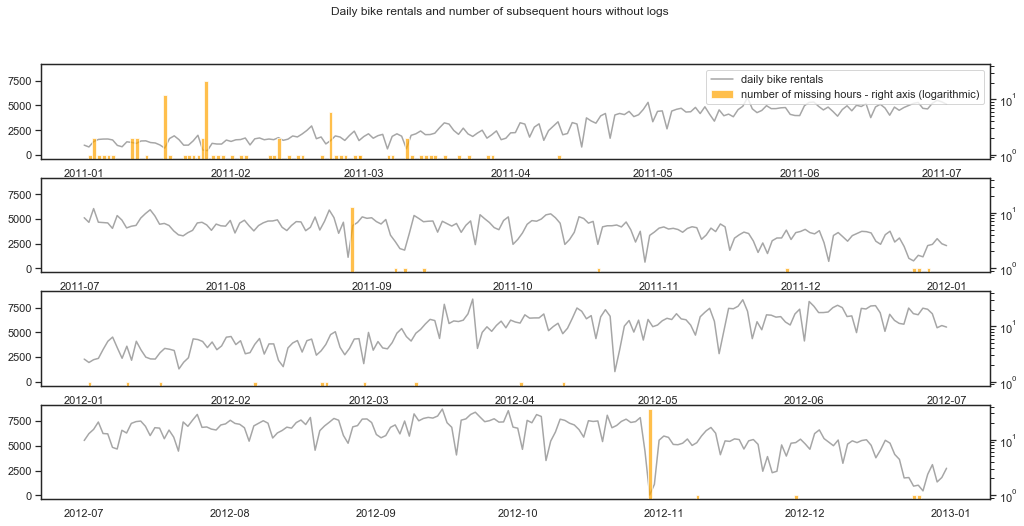

In [15]:
#we'll split in 4 subplots to better see the bars on the figure.
#As a split criteria, we'll use a middle point of a dteday field of df
min_date = df.dteday.dt.date.min()
max_date = df.dteday.dt.date.max()
center_date = min_date + (max_date - min_date)/2
second_quarter_date = min_date + (center_date - min_date)/2
third_quarter_date = center_date + (max_date - center_date)/2

dt_lims = [
    [min_date,second_quarter_date],
    [second_quarter_date,center_date],
    [center_date,third_quarter_date],
    [third_quarter_date,max_date + datetime.timedelta(days = 1)]
]

#aggregating rentals cnt at day level
series_for_trend_plot = df.set_index('dteday').resample('D').cnt.sum().asfreq('D')

#subplots generation
fig, axs = plt.subplots(nrows=len(dt_lims),figsize=(17,8), sharey = True)

#pandas needs this
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#the bar chart will be on secondary y, on primary we'll place cnt trend
#let's create list for twin axs
axs2 = [i.twinx() for i in axs]
#set shared y for secondary y axes
axs2[0].get_shared_y_axes().join(*axs2)

for i in range(len(dt_lims)):
    
    trendline = series_for_trend_plot[dt_lims[i][0]:dt_lims[i][1]]
    missing_logs = missing_hrs.loc[dt_lims[i][0]:dt_lims[i][1],'nr missing hrs']

    #adding cnt trend on the primary y
    l = axs[i].plot(trendline.index,
                trendline,
                color = 'grey',
                alpha = 0.7,
                label = 'daily bike rentals'
               )
    
    #adding missing_logs bars on secondary y
    b = axs2[i].bar(missing_logs.index,
                missing_logs,
                color = 'orange',
                alpha = 0.7,
                label = 'number of missing hours - right axis (logarithmic)')

    #make 2nd y axis on log scale to increase visibility
    axs2[i].set_yscale('log')
    
    #adding legend just on the first plot
    if i == 0:
        l_b = l+[b]
        labels = [lab.get_label() for lab in l_b]
        axs2[i].legend(l_b, labels)

plt.suptitle("Daily bike rentals and number of subsequent hours without logs")
plt.show()

In the beginning it was usual to have 1 - 2 hr break in rentals somewhere in the night. We can think of 2 reasons: either it was dictated by natural demand drop, or by rental availability (e.g. maintenance of all the bikes, system downtime).

We can see that in late spring - early autumn there were no breaks in logs. This speaks about demand decrease in low season's nights causing missing logs in low season nights.

Let's investigate the peaks. Most probably they were caused by some anomaly. Looking at the number of daily rentals line on the above figure, we see that prior the cases with long breaks in rental logs there was a decrease in rentals. Let's zoom in to see what was going on there.

In [16]:
#Adding weekday and month to the tabme with missing hours
missing_hrs["wk_day"] = missing_hrs.index.weekday
missing_hrs["mnth"] = missing_hrs.index.month
missing_hrs[missing_hrs["nr missing hrs"] > 2]

,index_log_before,nr missing hrs,wk_day,mnth
datetime_since,,,,
2011-01-18 00:00:00,395,12,1,1
2011-01-26 18:00:00,586,22,2,1
2011-02-22 00:00:00,1180,6,1,2
2011-08-27 18:00:00,5635,13,5,8
2012-10-29 01:00:00,15883,36,0,10


The table above contains all the rows which were the last before the breaks in rentals more than 2hrs happened. For a more complete understanding of the situation, we'll also need the rows, where the log restarted after break.

In [17]:
ix_filter = missing_hrs[missing_hrs["nr missing hrs"] > 2].index_log_before
ix_filter = sorted(ix_filter.tolist() + (ix_filter + 1).tolist())
filtered = df.iloc[ix_filter].drop(["season","yr","mnth","hr"], axis = 1)
filtered

,instant,dteday,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
395,396,2011-01-17 23:00:00,1,0,0,3,0.16,0.1364,0.86,0.2836,4
396,397,2011-01-18 12:00:00,0,1,1,2,0.20,0.1818,0.86,0.3284,3
586,587,2011-01-26 17:00:00,0,2,1,3,0.20,0.1818,0.93,0.3582,26
587,588,2011-01-27 16:00:00,0,3,1,1,0.22,0.2273,0.55,0.1940,24
1180,1181,2011-02-21 23:00:00,1,0,0,3,0.20,0.1667,0.75,0.4179,2
1181,1182,2011-02-22 06:00:00,0,1,1,2,0.12,0.1212,0.80,0.2836,7
5635,5636,2011-08-27 17:00:00,0,5,0,3,0.64,0.5758,0.89,0.8358,16
5636,5637,2011-08-28 07:00:00,0,6,0,3,0.62,0.5758,0.83,0.3582,1
15883,15884,2012-10-29 00:00:00,0,0,1,3,0.44,0.4394,0.88,0.3582,22
15884,15885,2012-10-30 13:00:00,0,1,1,3,0.30,0.2727,0.81,0.3582,116


We can check the average demand for rented bikes in the same year-month-hour to see if on log breaks there was a drop in numbers - this will indicate that something was happening there. We see that relative humidity is on the higher level for these rows, and for row 5635 the wind speed is very high as well. For all of the cases weathersit label is also high in the last hour before the break in logs for rentals. The temperatures, on the other hand, vary from low to mid-level as some of the cases happened in the winter, and some - in the summer. This might indicate that weather might have been a factor, which caused the decrease in bike rentals. We will check this for date 2011-08-27 as it has the most highest windspeed and humidity out of all.

But first, let's compare the number of rentals right before and immediately after the missing logs for all the cases vs average level for the same year-month-hour combinations, how bad they dropped. Then, we'll plot the trend lines 2 days before and 2 days after the missing logs for them.

In [18]:
filtered["YYYYMMHH"] = (filtered.dteday.dt.year * 10000 + filtered.dteday.dt.month*100 + filtered.dteday.dt.hour) 
df1 = df.copy()
df1["YYYYMMHH"] = (df1.dteday.dt.year * 10000 + df1.dteday.dt.month*100 + df1.dteday.dt.hour)
df1 = df1.pivot_table(values = "cnt", index = "YYYYMMHH", aggfunc = np.mean).reset_index()
filtered.merge(df1,
               left_on = "YYYYMMHH",
               right_on = "YYYYMMHH",
               how = "inner")[["dteday","cnt_x","cnt_y"]]

,dteday,cnt_x,cnt_y
0,2011-01-17 23:00:00,4,21.800000
1,2011-01-18 12:00:00,3,72.633333
2,2011-01-26 17:00:00,26,129.935484
3,2011-01-27 16:00:00,24,83.741935
4,2011-02-21 23:00:00,2,35.535714
5,2011-02-22 06:00:00,7,22.607143
6,2011-08-27 17:00:00,16,458.322581
7,2011-08-28 07:00:00,1,231.096774
8,2012-10-29 00:00:00,22,76.733333
9,2012-10-30 13:00:00,116,375.733333


Indeed, the actual number of rented bikes was much lower than the mean for the same hour in the same month. Let's create a visualization of the change of bike rentals within some timeperiod which should include the period with missing logs. For this, we can create a function that will create a slice of data for the period n-days before and k-days after the specified date. In order to better understand how the numbers deviate from norm, the function will also return  the slices of data with similar number of frequency periods that will contain the data for other same weekdays within the month of the specified date.

In [19]:
import calendar

#we'll write a function to return slices of df with specified days before and after
def find_avg_trend(date_instant, days_before = 2, days_after = 2, df = df):

    date_instant_year = date_instant.year
    date_instant_month = date_instant.month
    date_instant_day = date_instant.day
    date_instant_weekday = date_instant.weekday()

    left = datetime.datetime(year = date_instant_year,
                             month = date_instant_month,
                             day = date_instant_day) - datetime.timedelta(days = days_before)

    monthrange = calendar.monthrange(date_instant_year,date_instant_month)

    next_month = (datetime.datetime(year = date_instant_year, month = date_instant_month, day = monthrange[1])
                  + datetime.timedelta(days = 1))

    monthrange_series = pd.date_range(start = datetime.datetime(year = date_instant.year,
                                                month = date_instant.month,
                                                day = 1),
                                      end = next_month,
                                      closed = 'left',
                                      freq = '1D')
    
    left_similar = list(monthrange_series[monthrange_series.weekday == left.weekday()])

    df_segments = []
    df_frequency = df.reset_index().set_index('dteday').asfreq('1H').sort_index()

    for l in left_similar:

        r = l + datetime.timedelta(hours = (days_before + days_after + 1)*24-1)
        df_segment = df_frequency[l:r].reset_index().set_index('index')
        df_segments.append(df_segment)

    main_period_df = df_segments.pop(left_similar.index(left))
    return(main_period_df, df_segments)

We are now ready to plot the zoomed-in graphs for all the cases with prolonged missing logs of bike rentals. With the help of the written function, we can actually plot not only the 'cnt' column, but also weather columns as well.

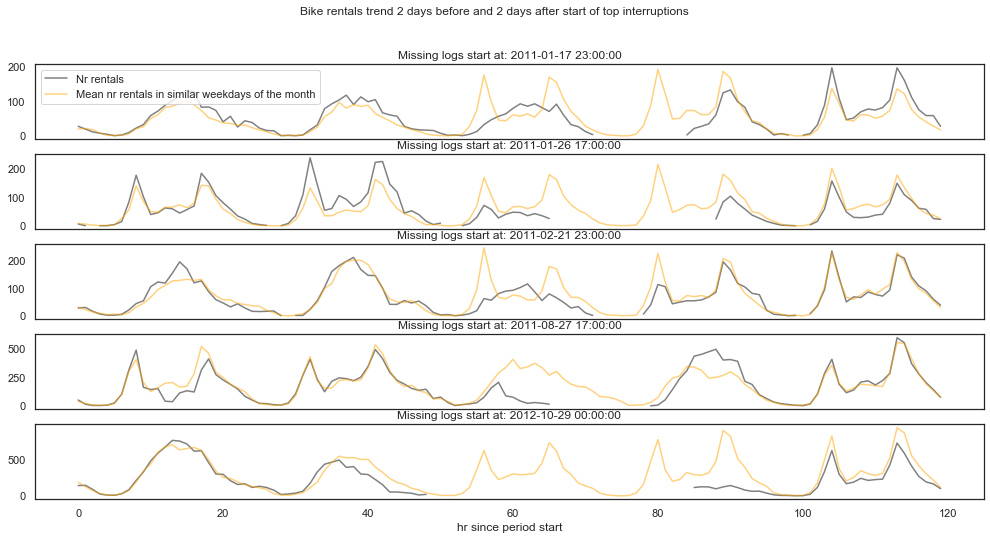

In [20]:
dates_before_mis_logs = df.iloc[missing_hrs[missing_hrs["nr missing hrs"] > 2].index_log_before]["dteday"].copy()
fig, axs = plt.subplots(nrows = dates_before_mis_logs.shape[0], figsize = (17,8), sharex = True)

for i in range(dates_before_mis_logs.shape[0]):
    
    slice_main, slices_other = find_avg_trend(dates_before_mis_logs.iloc[i], days_before = 2, days_after = 2, df = df)
    main_period_cnt = slice_main.cnt.values
    other_periods_cnt_mean = np.mean([table.cnt.fillna(0).values for table in slices_other], axis=0)
    
    axs[i].plot(main_period_cnt, color = 'grey', label = 'Nr rentals')
    axs[i].plot(other_periods_cnt_mean, color = 'orange', alpha = 0.5, label = 'Mean nr rentals in similar weekdays of the month')
    axs[i].set_title('Missing logs start at: ' + str(dates_before_mis_logs.iloc[i]))
    
    if i == 0:
        axs[i].legend()
plt.suptitle("Bike rentals trend 2 days before and 2 days after start of top interruptions")
plt.xlabel('hr since period start')
plt.show()

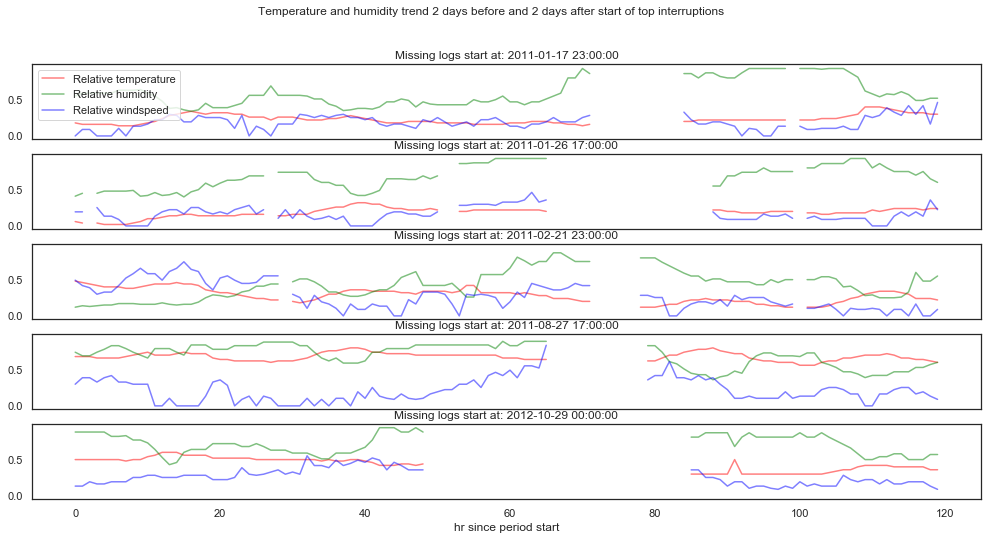

In [21]:
fig, axs = plt.subplots(nrows = dates_before_mis_logs.shape[0], figsize = (17,8), sharex = True, sharey = True)

for i in range(dates_before_mis_logs.shape[0]):
    
    slice_main, slices_other = find_avg_trend(dates_before_mis_logs.iloc[i], days_before = 2, days_after = 2, df = df)
    main_period_temp = slice_main.temp.values
    main_period_hum = slice_main.hum.values
    main_period_ws = slice_main.windspeed.values

    axs[i].plot(main_period_temp, color = 'red', alpha = 0.5, label = 'Relative temperature')
    axs[i].plot(main_period_hum, color = 'green', alpha = 0.5, label = 'Relative humidity')
    axs[i].plot(main_period_ws, color = 'blue', alpha = 0.5, label = 'Relative windspeed')
    axs[i].set_title('Missing logs start at: ' + str(dates_before_mis_logs.iloc[i]))
    
    if i == 0:
        axs[i].legend()
plt.suptitle("Temperature and humidity trend 2 days before and 2 days after start of top interruptions")
plt.xlabel('hr since period start')
plt.show()

In the above figures we can see that in case 1 and 2 bike rentals do not follow the average trend for the same week days within their months. This might be an indication of holidays, and indeed there was Martin Luther King Jr. Day on Jan 17 and Washington's Birthday on Feb 21. In both cases the average bike rentals are lower than for Sundays before them, which might be a pattern for holidays happening after weekends. Or, more probably, it might be due to the significant humidity increase, which is obvious on the second figure. With these cases happening in low season, it should not be a surprize that the the demand for bikerentals might have disappeared in the night hours with bad weather.

For cases 4 and 5 we see that bikerentals follow the average trend closely and then start decreasing. In the case 5, the trend does not recover immediately - we know that there was a hurricane Sandy that day, which explains such prolonged absense of rentals. Googling for 2011-08-27 gave us the info that there also was a Hurricane Irine. 

For 2011-01-26 Google says that there was heavy snowing, which surely should have affected bikes usage due to it being so severe to be in the news headlines.

On the second figure above for all the cases we see worsening of the weather conditions prior the drop of bike rentals to zero.

Overall, now we know that these anomalies were the effect of bad weather and some other events. We also know that the dataset is not a datetime frequency, and 'instant' field does not really makes much sense. While it will definitely improve the quality of the data set, we will not try to convert it to the format with the same datetime lag for all rows. However, we will change 'instant' column a bit so that it contains the information that there were missing logs. It might be helpful for regression models.

Moreover, we can label the found events as anomalies in order to gain some marginal improvement of prediction models in the future. However, we'll not spend more time on events labeling a it is not the main focuse in this analysis.

Let's finish our preliminary study with transformation of the 'instant' column.

In [22]:
df['instant'] = df.set_index('dteday').asfreq('1H').reset_index().dropna().index
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,0,2011-01-01 00:00:00,1,0,1,0,0,5,0,1,0.24,0.2879,0.81,0.0000,16
1,1,2011-01-01 01:00:00,1,0,1,1,0,5,0,1,0.22,0.2727,0.80,0.0000,40
2,2,2011-01-01 02:00:00,1,0,1,2,0,5,0,1,0.22,0.2727,0.80,0.0000,32
3,3,2011-01-01 03:00:00,1,0,1,3,0,5,0,1,0.24,0.2879,0.75,0.0000,13
4,4,2011-01-01 04:00:00,1,0,1,4,0,5,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17539,2012-12-31 19:00:00,1,1,12,19,0,0,1,2,0.26,0.2576,0.60,0.1642,119
17375,17540,2012-12-31 20:00:00,1,1,12,20,0,0,1,2,0.26,0.2576,0.60,0.1642,89
17376,17541,2012-12-31 21:00:00,1,1,12,21,0,0,1,1,0.26,0.2576,0.60,0.1642,90
17377,17542,2012-12-31 22:00:00,1,1,12,22,0,0,1,1,0.26,0.2727,0.56,0.1343,61


## Understanding the trend

We have already seen that the bkie rentals are affected both by time and weather parabeters. It is also greatly reliant on the external events, such as holidays, weather anomalies, political events. Moreover, it is dependant on the number of stations, bicycles, city planning, transport situation, pollution, change of social habits etc. In this analysis we will focus on the basics: trend change with time.

If we think of bike rentals as a function of time and weather, we can come to the following thoughts:
1. Bikerentals should be more dependant on weather, than on time. But weather parameters change with time: there is yearly and daily seasonalities, and might be some more, which could be dictated by relative earth positions in space and processes in the Sun and the Earth's core.
2. Most people show different behavioral patterns on working days, weekends and holidays. But these patterns vary with the weather conditions and the length of a day. 
3. The actual numbers of bike rentals might be constrained by the capacity of the system. It might grow with the development of the bike rental system. It can also be changing over time due to the changes in social demands and perception of bike rentals. 

Overall, we can expect to see some general trendline, which is time dependant, and seasonalities, which are time and weather dependant. 

Let's look at the change of bike rentals over time at different aggregation levels to study the patterns. First, we need to understand the general trend.

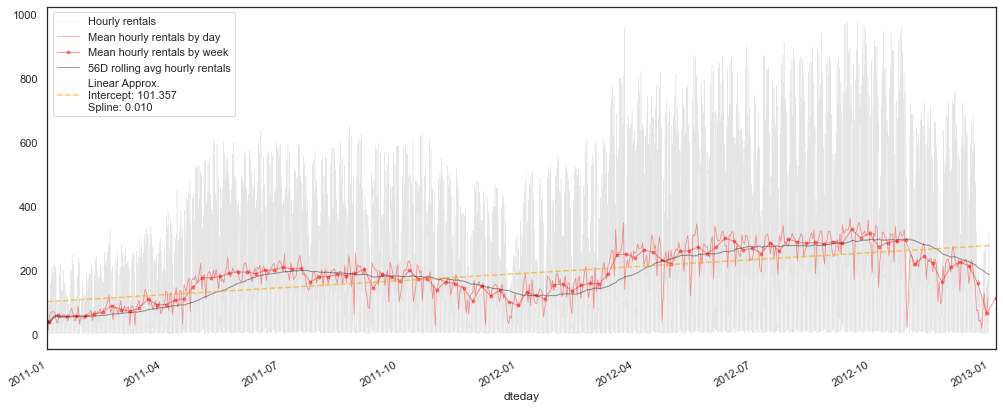

In [23]:
df_for_trend = df.copy().set_index("dteday")

#plotting lines
ax = df_for_trend.cnt.plot(figsize = (17,7), alpha = 0.2, color = 'grey', linewidth = 0.5, label = 'Hourly rentals')
df_for_trend.resample('D').mean().cnt.plot(ax = ax, alpha = 0.4, linewidth = 0.8, color = "red", label = 'Mean hourly rentals by day')
df_for_trend.resample('W').mean().cnt.plot(ax = ax, alpha = 0.4, linewidth = 1, color = "red", marker = '.', label = 'Mean hourly rentals by week')
df_for_trend.rolling('56D').mean().cnt.plot(ax = ax, alpha = 0.4, linewidth = 1, color = "black", label = '56D rolling avg hourly rentals')

#plotting trendline
lr_matrix = pd.concat([pd.Series(1, index=df_for_trend.index), df_for_trend.instant], axis = 1)
X = lr_matrix
Y = df_for_trend.cnt

coeffs = np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T, Y))
Y1 = pd.Series(np.dot(X, coeffs.T), index = df_for_trend.index,name = 'lin_approx')
Y1.plot(ax = ax, alpha = 0.6, linestyle = "--", color = "orange",
        label = "Linear Approx.\nIntercept: {:.3f}\nSpline: {:.3f}".format(coeffs[0],coeffs[1]))

ax.legend()
plt.show()

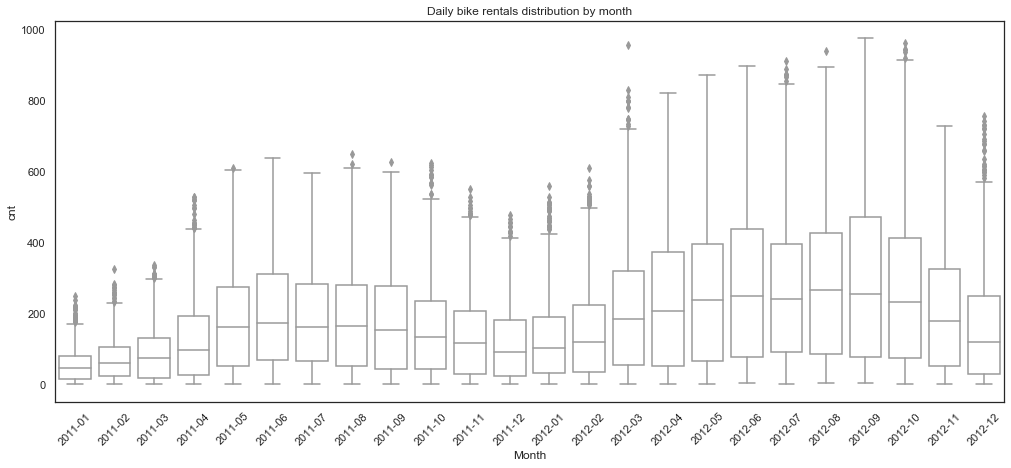

In [24]:
fig, ax = plt.subplots(figsize = (17,7))
sns.boxplot(x=df_for_trend.index.to_period('M'), y = df_for_trend["cnt"], ax = ax, color = "white")
plt.xticks(rotation = 45)
plt.title("Daily bike rentals distribution by month")
ax.set_xlabel ("Month")
plt.show()

We see a clear monthly seasonality. In late Spring and early Autumn the number of bike rentals is 2 times higher on average. We can also notice that the number of bike rentals increased by more than 2 times over 2 years.

Let's find seasonality coefficients for months, weekdays and hours.

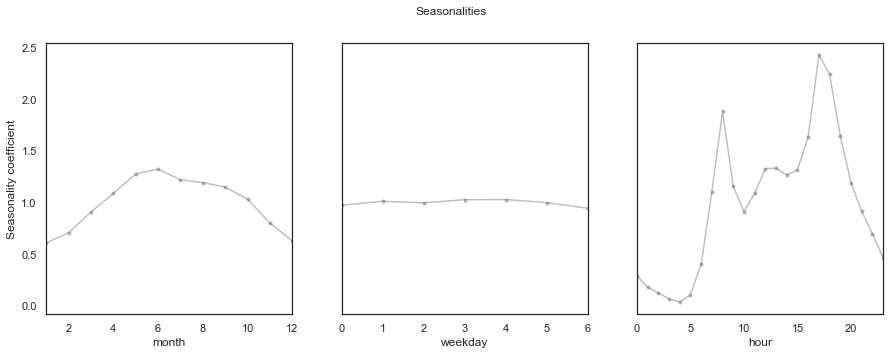

In [25]:
seasonality_c = (Y / Y1)

seasonality_yearly = seasonality_c.groupby(seasonality_c.index.month).mean()
seasonality_wd = seasonality_c.groupby(seasonality_c.index.weekday).mean()
seasonality_d = seasonality_c.groupby(seasonality_c.index.hour).mean()

seasonality_srs = [seasonality_yearly,seasonality_wd,seasonality_d]
lbls = ['month','weekday','hour']
fig,axs = plt.subplots(ncols = 3,figsize = (15,5), sharey = True)

for i in range(3):
    seasonality_srs[i].plot(ax = axs[i], legend = False, color = "grey", alpha = 0.5, marker = '.')
    axs[i].set_xlabel(lbls[i])
axs[0].set_ylabel("Seasonality coefficient")
plt.suptitle("Seasonalities")

plt.show()

It is also interesting to see how the trend changes with season and what is the difference between working and non-working days. Let's plot the mean nr of hourly rentals now to also see the change in level of demand. 

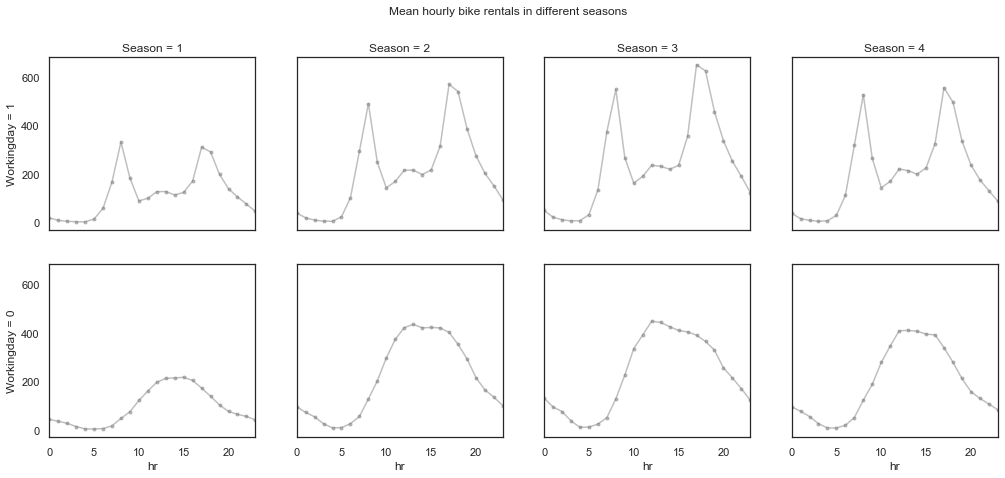

In [26]:
seasonality_c1 = (Y / df_for_trend.rolling('14D').mean().cnt)
seasonality_c1.name = 'seasonality_c'
df_for_trend1 = pd.concat([df_for_trend,seasonality_c1], axis = 1)

wh_seasonalities = df_for_trend1.groupby(['season','workingday',df_for_trend1.index.hour.rename('hr')]).cnt.mean()
wh_seasonalities_pivot = wh_seasonalities.reset_index().pivot_table(values = 'cnt', columns = ['workingday', 'season'], index = 'hr')

fig,axs = plt.subplots(ncols = 4, nrows = 2, figsize = (17,7), sharey = True, sharex = True)

for i in range(2):
    wh_seasonalities_pivot[i].plot(subplots = True, ax = axs[i-1], legend = False, color = "grey", alpha = 0.5, marker = '.')
    axs[i-1, 0].set_ylabel("Workingday = {}".format(i))
for i in range (1,5):
    axs[0,i-1].set_title("Season = {}".format(i))
plt.suptitle("Mean hourly bike rentals in different seasons")
plt.show()

On the above charts we can see that the shapes remain the same with variation of seasons and workingdays. The only noticeable features are the increase of overall level of demand and a slightly more spread graph for non-working summer days.


## Labeling hourly data

The last excersise of this project will be focused on assessment of different prediction models for bike rentals data. In order to have a better prediction accuracy, we need to find some patterns in our data, that would be useful.

We have already found 5 cases with long breaks in logs, and noticed that the demand for bikes was very low at these days vs average. We can either label them as anomalies or drop as noize.

There are also other labels, which we could add:

- hourly segmentation of demand trend, which we'll do now
- segmentation by weather conditions, which we'll do after studying weather parameters

Based on the hourly bike rentals trend from the above figure, we can distinguish 6 hour segments:

- 00hr - 06hr
- 09hr - 12hr
- 12hr - 16hr
- 16hr - 20hr
- 20hr - 24hr

Let's add these labels to the data and visually check if they coud be useful for increasing the accuracy of further prediction excersise.

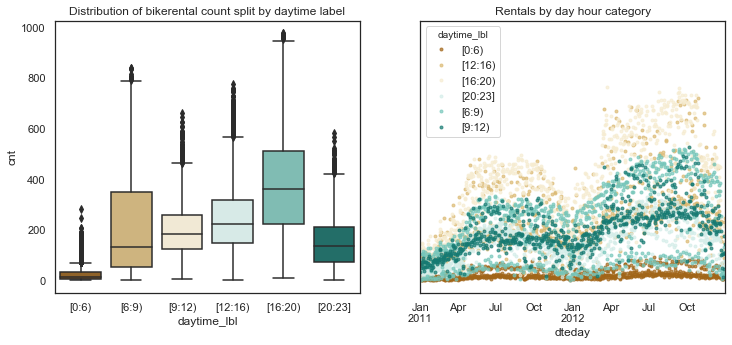

In [27]:
df1 = df_for_trend
df1['daytime_lbl'] = "[0:6)"
df1.loc[(df1.index.hour >= 6) & (df1.index.hour < 9), 'daytime_lbl'] = "[6:9)"
df1.loc[(df1.index.hour >= 9) & (df1.index.hour < 12), 'daytime_lbl'] = "[9:12)"
df1.loc[(df1.index.hour >= 12) & (df1.index.hour < 16), 'daytime_lbl'] = "[12:16)"
df1.loc[(df1.index.hour >= 16) & (df1.index.hour < 20), 'daytime_lbl'] = "[16:20)"
df1.loc[(df1.index.hour >= 20) & (df1.index.hour < 24), 'daytime_lbl'] = "[20:23]"

fig, axs = plt.subplots(ncols = 2, figsize = (12,5), sharey = True)
c = sns.color_palette("BrBG", 6)
sns.boxplot(data = df1, x = "daytime_lbl", y = "cnt", ax = axs[0], palette = c)
axs[0].set_title("Distribution of bikerental count split by daytime label")

df2 = df1.pivot_table(values = "cnt", columns = "daytime_lbl", index = df1.index.to_period('D'))
df2.plot(marker='.', alpha=0.7, linestyle='None', ax = axs[1], color = c)
axs[1].set_title("Rentals by day hour category")
plt.show()

From the above figure we see that each daytime segment has its distinct features and is well separated from the other segments.

## Weather parameters analysis

We  have an ordinal data field 'weahersit', which represents weather situation label. In the [data specification](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset), it is stated, that this field cathegorizes the weather by the following parameters:

- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

This categorization does not provide full information about the weather. For a more complete picture, we have 4 other continuous normalized fields (temp, atemp, hum, windspeed), which we could use for clustering.

First, let's analyze the 'weathersit' field to understend how it affects bike rentals and how it varies with the change of other weather paremeters.

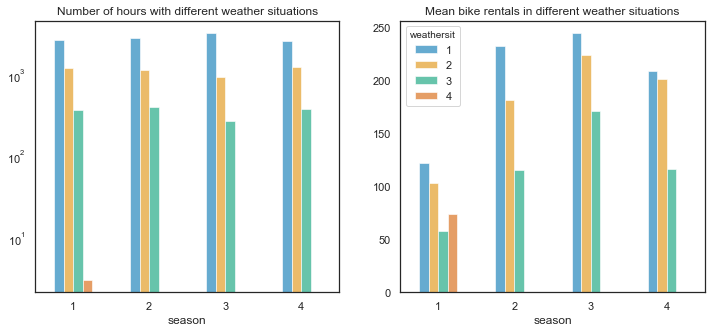

In [28]:
fig,axs = plt.subplots(ncols = 2, figsize = (12,5))
c = sns.color_palette("colorblind", 4)
season_weather_ctab = pd.crosstab(df1['season'],
                                   df1['weathersit'],
                                   values = df1['cnt'],
                                   aggfunc = [np.size,np.mean]).fillna(0).astype(int)
season_weather_ctab['size'].plot.bar(alpha = 0.6, color = c, logy = True, ax = axs[0],
                                     title = 'Number of hours with different weather situations', legend = False, rot = 0)
season_weather_ctab['mean'].plot.bar(alpha = 0.6, color = c, ax = axs[1],
                                     title = 'Mean bike rentals in different weather situations', rot = 0),
plt.show()

The above figure tells us that there were extremely little number of cases with weathersit = 4 - only 3 hours. The weather situation is tipically better in the summer. Looking at the mean number of rentals, we can say that in the spring there were relatively more overall rentals with weathersit = 1 vs other seasons. It might be either due to social reaction to better weather after the winter, or due weather = 1 better aligning with peak hours for bike rentals in spring. Let's add hour dimension to the above plot in order to see this.

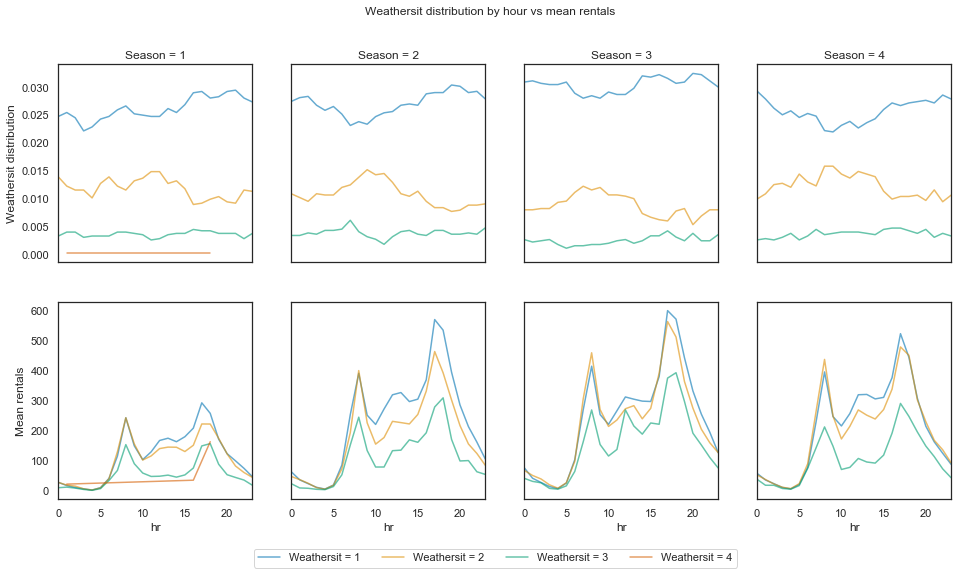

In [29]:
#instantiating subplots
fig,axs = plt.subplots(ncols = 4, nrows = 2, figsize = (16,8), sharex = True)

#set shared y
axs[0][0].get_shared_y_axes().join(*axs[0])
axs[1][0].get_shared_y_axes().join(*axs[1])

#some labels for text on plots
seasons_labels = sorted(df1['season'].unique().tolist())
weathersit_labels = sorted(df1['weathersit'].unique().tolist())

for i in range(len(seasons_labels)):
    
    #weight based on share of weathersit in season
    weights = df1[df1['season'] == seasons_labels[i]]['weathersit'].value_counts(normalize = 1)
        
    for j in range(len(weathersit_labels)):
        df1_ij_indexer = ((df1['weathersit'] == weathersit_labels[j]) & 
                          (df1['season'] == seasons_labels[i]))

        #if there is no weathersit label in season
        #there's nothing to plot
        if df1_ij_indexer.sum() > 0:
            df_ij = df1[df1_ij_indexer]
            df_ij_freq = df_ij.index.hour.value_counts(normalize = True).sort_index()
            df_ij_weighted = df_ij_freq*weights[weathersit_labels[j]]
            df_ij_mean_cnt = df_ij.groupby(df_ij.index.hour)['cnt'].mean()
            
            l1 = axs[0][i].plot(df_ij_weighted,
                             label = 'Weathersit = {}'.format(weathersit_labels[j]),
                             color = c[j],
                             alpha = 0.6)
            
            axs[1][i].plot(df_ij_mean_cnt,
                             label = 'Weathersit = {}'.format(weathersit_labels[j]),
                             color = c[j],
                             alpha = 0.6)

    #adding text and formatting    
    axs[0][i].set_title('Season = {}'.format(seasons_labels[i])) 
    axs[1][i].set_xlabel('hr')

    if i != 0:
        axs[0][i].yaxis.set_visible(False)
        axs[1][i].yaxis.set_visible(False)

#some other formatting
axs[0][1].set_xlim((0,23))
axs[0][0].set_ylabel('Weathersit distribution')
axs[1][0].set_ylabel('Mean rentals')
    
# Put a legend below
labels = [lab.get_label() for lab in axs[0][0].lines]

fig.legend(axs[0][0].lines, labels, bbox_to_anchor=(0.43, 0), loc='lower center',ncol=5)

fig.suptitle('Weathersit distribution by hour vs mean rentals')
plt.show()

We plotted 8 graphs, which are showing the same information as previous charts, but with hourly perspective:

The first row represents frequency distributions of weathersit by hour. The frequencies are weighted by the share of weathersit in the season (count of hours). The sum of all values on a single plot is 1.

The second row shows mean hourly bike rentals in different weathersit. 

We can see morning peak hours are very similar in terms the demand for rentals for weathersit 1 and 2, whereas the evening peak is higher on average for weathersit = 1. And for winter and spring times it has more separated from the next line.
it can be due to weathersit 2 in winter and spring being more severe than in summer and fall. Or it could be due to effect of suppressed demand for physical outdoors activity due to a bit worse on average weather in the morning for these seasons, which result in increase of rentals in the evening time, when it becomes a better.

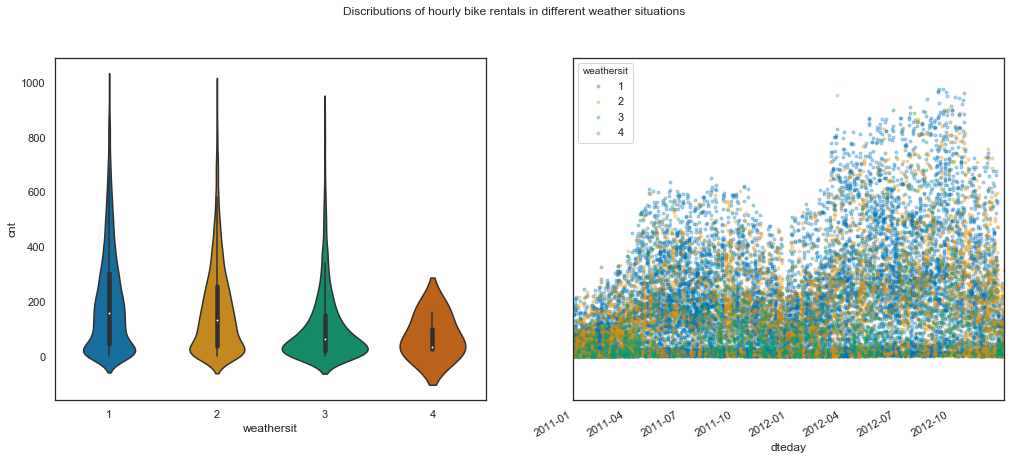

In [30]:
fig, axs = plt.subplots(ncols = 2, figsize = (17,7), sharey = True)
sns.violinplot(data = df1, x = "weathersit", y = "cnt", ax = axs[0], palette = c)

df.pivot_table(values = "cnt", columns = "weathersit", index = "dteday").plot(marker = ".",
                                                                              linestyle = "None",
                                                                              alpha = 0.3,
                                                                              figsize = (17,7),
                                                                              color = c,
                                                                              ax = axs[1])
fig.suptitle("Discributions of hourly bike rentals in different weather situations")
plt.show()

As we see from the specification, this field is ordinal, but the difference between different levels is, well, different. If we think about it, thunderstorms or snowing affects the decision for using bikes on these days much more than knowing that it will not be sunny, but rather a bit cloudy. We can see this on the violin plot above: the median value for bike rentals does not decrease linearly - it is more affeted by higher number of weathersit indicator. Moreover, the distributions change differently as well: for weathersit 1 and 2 they are very similar, whereas for 3 it is much more right-skewed. For weathersit 4 it is hard to tell anything at there were only 3 such cases registered.

That being said, we should already get the feeling that transforming these ordinal labels to dummy variables should provide us better overall in regression models, as the effect from increase of the order of label on bike rentals is not linear.

From the distribution of weathersit on timeline, we see that it does not distinctly separate winter from summer. Let's check how it varies with other weather parameters and then we'll create some new labels out of them.

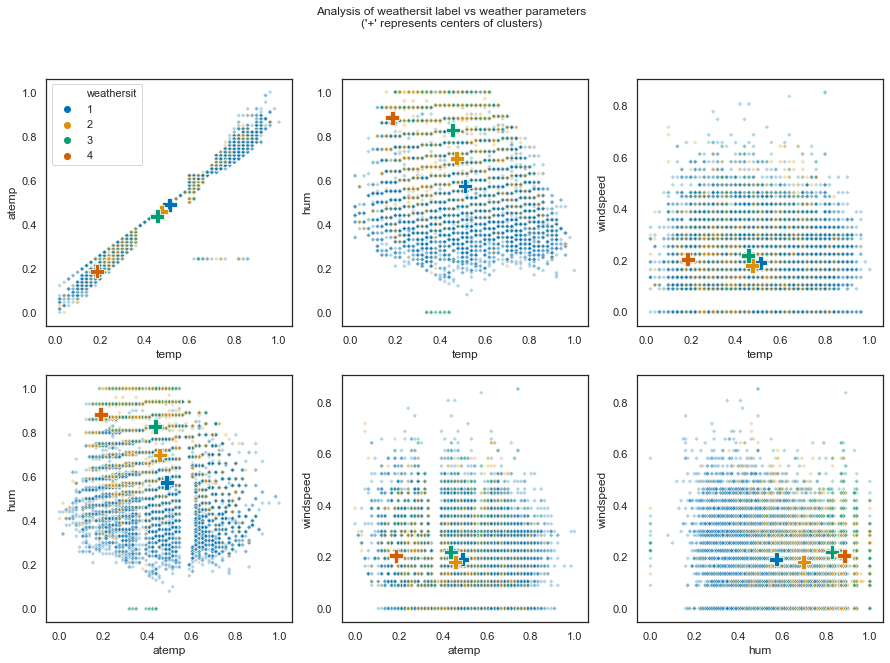

In [31]:
fig,axs = plt.subplots(ncols = 3, nrows = 2, figsize = (15,10))
weather_continuous_cols = ["temp", "atemp","hum","windspeed"]
weather_cols_comb = combinations(weather_continuous_cols, 2)
weather_cols_comb = [list(i) for i in list(weather_cols_comb)]

centers = df1.pivot_table(values = weather_continuous_cols, index = "weathersit").sort_index()

for i in range(len(weather_cols_comb)):
    if i > 0:
        legend = False
    else:
        legend = "full"
    sns.scatterplot(data = df1,
                    x = weather_cols_comb[i][0],
                    y = weather_cols_comb[i][1],
                    hue = "weathersit",
                    alpha = 0.3,
                    ax = axs.flatten()[i],
                    palette = c,
                    marker = "D",
                    s = 10,
                    legend = False)
    sns.scatterplot(data = centers,
                    x = weather_cols_comb[i][0],
                    y = weather_cols_comb[i][1],
                    hue = centers.index,
                    ax = axs.flatten()[i],
                    palette = c,
                    legend = legend,
                    marker = "P",
                    s = 200)
fig.suptitle("Analysis of weathersit label vs weather parameters\n('+' represents centers of clusters)")
plt.show()

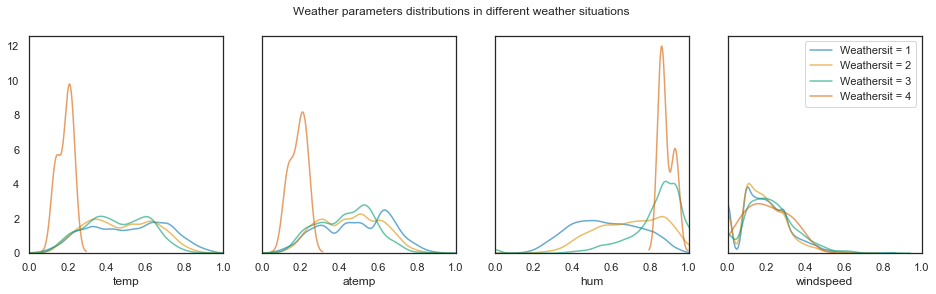

In [32]:
fig,axs = plt.subplots(ncols = 4, figsize = (16,4), sharey = True, sharex = True)
for i in range(len(weather_continuous_cols)):
    if i == len(weather_continuous_cols) - 1:
        legend_visible = True
    else:
        legend_visible = False
    for j in range(len(weathersit_labels)):
        df_ij = df1[df1['weathersit'] == weathersit_labels[j]][weather_continuous_cols[i]]
        sns.kdeplot(df_ij,
                    ax = axs[i],
                    label = 'Weathersit = {}'.format(weathersit_labels[j]),
                    color = c[j],
                    legend = legend_visible,
                    alpha = 0.6)
        axs[i].set_xlabel(weather_continuous_cols[i])
        axs[i].set_xlim((0,1))
fig.suptitle('Weather parameters distributions in different weather situations')
plt.show()

What we see is that humidity it the most important factor for weathersit - with higher humidity weathersit 3 occur more often. A bit lower temperature is also a feature for these conditions.With the windspeed we see that the distribution is a bit less sqewed to the right than for weathersit 1 and 2. In sum, it looks very logical.

Let's see how bike rentals vary with weather parameters.

In [33]:
weather_ranges = []
for i in weather_continuous_cols:
    ranges = pd.cut(df1[i], bins=np.arange(0,1.01,0.05),include_lowest = True)
    mids = pd.Series(pd.IntervalIndex(ranges).mid, name = i, index = df1.index)
    weather_ranges.append(mids)

mean_cnt_by_weather = pd.concat(weather_ranges +[df1.cnt], axis = 1)

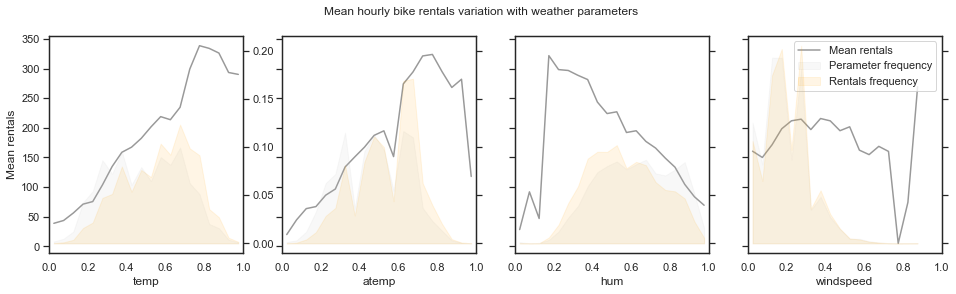

In [34]:
from scipy.stats import gaussian_kde as kde
cols_num = len(weather_continuous_cols)

fig,axs = plt.subplots(ncols = cols_num, figsize = (16,4), sharex = True, sharey = True)

#setting shared secondary y
axs2 = [i.twinx() for i in axs]
axs2[0].get_shared_y_axes().join(*axs2)

#instantiate X_mash and freq for kdes
X_mash = np.mgrid[0:1:.05]
freq = df1.cnt

#start plotting
for i in range(cols_num):
    #primary axis - mean
    XY = mean_cnt_by_weather.groupby(weather_continuous_cols[i]).cnt.mean()
    XY.plot(ax = axs[i],
            color = 'grey',
            alpha = 0.8,
            label = 'Mean rentals')
    
    #2nd axis - kde
    X1_freq = mean_cnt_by_weather[weather_continuous_cols[i]].value_counts(normalize = 1).sort_index()
    axs2[i].fill_between(X1_freq.index,X1_freq,
                        color = 'silver',
                        alpha = 0.1,
                        label = 'Perameter frequency')
            
    #2nd axis - kde
    X2_freq = mean_cnt_by_weather[weather_continuous_cols[i]].repeat(mean_cnt_by_weather.cnt).value_counts(normalize = 1).sort_index()
    axs2[i].fill_between(X2_freq.index,X2_freq,
                 color = 'orange',
                 alpha = 0.1,
                 label = 'Rentals frequency')
    
    #add xlabel
    axs[i].set_xlabel(weather_continuous_cols[i])
axs[0].set_xlim((0,1))
#add ylabel
axs[0].set_ylabel('Mean rentals')
axs2[-1].set_ylabel('Density')
#add legend
handles, labels = axs[0].get_legend_handles_labels()
handles1, labels2 = axs2[0].get_legend_handles_labels()
axs[-1].legend(handles + handles1, labels + labels2, loc = 'upper right')
plt.suptitle('Mean hourly bike rentals variation with weather parameters')
plt.show()

On the chart we see that the mean hourly bike rentals have almost linear dependency from temperature. However, after temp around 0.8, the number of mean rentals start decreasing. Looking at atemp, we see that this drop is even more vivid - this might indicate that at higher temperatures it people start choosing other activities than cycling. Bike rentals frequency by temperature distribution is more skewed to the left than the frequency of temperatures - this speaks of the fact that more people cycle at higher temperatures.

We also see that lower humidity is also better for cycling. Yet, such cases are relatively rare. When they occur, there is more demand for bicycle rental services.

Looking at the variation of rentals with windspeed, we can think of the following explanation: wind is on average slower in the nights, or at mild weather conditions, when the demand for bike sharing is also lower on average. This explains the mean rentals at less windy times being not the highest. However, when it is more windy, rentals start decreasing as well. We see mean rentals going up at windspeed 0.8 and higher, but such cases are so rare that we could assume them to be statistical errors.

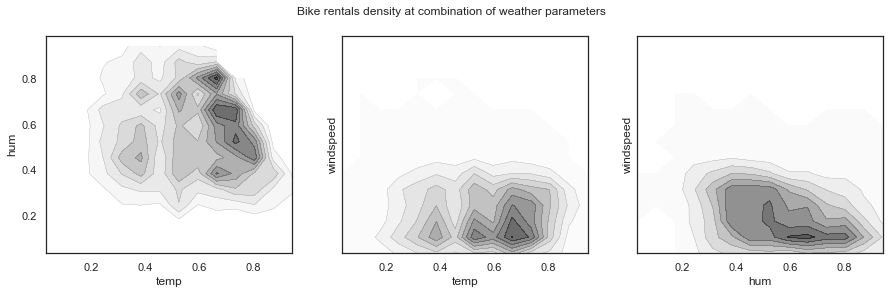

In [35]:
#let's aggregate on higher level
weather_ranges = []
for i in weather_continuous_cols:
    ranges = pd.cut(df1[i], bins=np.arange(0,1.01,0.07),include_lowest = True)
    mids = pd.Series(pd.IntervalIndex(ranges).mid, name = i, index = df1.index)
    weather_ranges.append(mids)
#let's plot without atemp
mean_cnt_by_weather1 = pd.concat(weather_ranges +[df1.cnt], axis = 1)
weather_cols_wo_atemp = [i for i in weather_continuous_cols if i != 'atemp']
cols_num = len(weather_cols_wo_atemp)

weather_cols_wo_atemp_comb = combinations(weather_cols_wo_atemp, 2)
weather_cols_wo_atemp_comb = [list(i) for i in list(weather_cols_wo_atemp_comb)]
cols_comb_num = len(weather_cols_wo_atemp_comb)

fig,axs = plt.subplots(ncols = cols_comb_num, nrows = 1,
                       figsize = (15,4), sharex = True, sharey = True)

#start plotting
for i in range(cols_comb_num):
    Z = mean_cnt_by_weather1.pivot_table(index = weather_cols_wo_atemp_comb[i][1],
                               columns = weather_cols_wo_atemp_comb[i][0],
                               values = 'cnt',
                               aggfunc = sum)
    Z_flat = Z.melt()
    vmin = Z_flat[Z_flat.value != 0].value.quantile(0.3)
    axs[i].contour(Z.columns,
                 Z.index,
                 Z,
                 colors='k',
                 alpha = 0.5,
                 linewidths=0.2,
                 levels=10,
                 vmin = vmin)
    axs[i].contourf(Z.columns,
                     Z.index,
                     Z,
                     cmap="Greys",
                     alpha = 0.7,
                     levels=10,
                     vmin = vmin)
    axs[i].set_xlabel(weather_cols_wo_atemp_comb[i][0])
    axs[i].set_ylabel(weather_cols_wo_atemp_comb[i][1])
plt.suptitle("Bike rentals density at combination of weather parameters")
plt.show()

In [36]:
from scipy.stats import mode
print('Bike rentals weather stats:')
for i in weather_continuous_cols:
    weather_params = mean_cnt_by_weather1[i].repeat(mean_cnt_by_weather1.cnt)
    print(i,
          '-- mode: ',
          round(mode(weather_params)[0][0],3),
          'median: ',
          round(weather_params.median(),3))
print()
weather_params1 = mean_cnt_by_weather1.groupby(weather_continuous_cols).cnt.sum().sort_values(ascending = False)
weather_params_top = weather_params1[weather_params1 >= weather_params1.quantile(0.99)].reset_index()
print('Top 1% of rentals happened at:')
for i in weather_continuous_cols:
    print(i, round(weather_params_top[i].min(),3), '-', round(weather_params_top[i].max(),3))

Bike rentals weather stats:
temp -- mode:  0.665 median:  0.595
atemp -- mode:  0.665 median:  0.595
hum -- mode:  0.455 median:  0.525
windspeed -- mode:  0.105 median:  0.175

Top 1% of rentals happened at:
temp 0.525 - 0.735
atemp 0.525 - 0.665
hum 0.385 - 0.805
windspeed 0.105 - 0.315


Looking at bike rentals densities at combined weather parameters, we see that rides happened more frequently at around temp 0.665, hum 0.455 and windspeed 0.105.

### Labels for weather

Let's move forwards with creating another weather categorization based on combinations of the four continuous weather representation fields that are present in the dataset, weathersit and daytime labels. We'll utilize k-means clustering technique for that.

We will not spend time here selecting the best number of clusters using the silhouette score, as this will be too time consuming. However, we can use the following logic for choosing it: (6 day times * 4 seasons * 3 weather situations) = 72. 

It is worth mentioning here that we will not use the bike rentals numbers in our clusterization excercise. However, we will order the labels by the mean rentals in order to get better performance of linear regression. It might be one of the flaws of this study, but we'll still do this. Afterall, this excersize could have been done similarly on a subset of data, if olabels ordered by relative rentals to trend line. Still we acknowledge that it would be better to split the dataset to test and train sets, do clusterization for the train set and look how it improves predictions on the test set.

Let's create these labels now.

In [37]:
df_clustering = df1[weather_continuous_cols + ['cnt']].copy()
# normalizing weathersit
df_clustering['weathersit'] = (df1['weathersit'] - df1['weathersit'].min())/df1['weathersit'].max()

In [38]:
from sklearn.metrics import silhouette_score
n_clusters = 72

#let's track the time it takes for clusterization cycles
import time
start_time = time.time()

km = KMeans(n_clusters=n_clusters, random_state = 0, algorithm = "full").fit(df_clustering[weather_continuous_cols
                                                                                           + ['weathersit']])

#print time in seconds
print("--- {:.2f} seconds ---".format(time.time() - start_time))

--- 16.28 seconds ---


We see that calculating only one simple clusterization took several seconds. That's why we are not experimenting with number of clusters.

Let's visualize the result of labeling the data based on weather conditions. But first, we should redo our clusterization and order the procuced labels in a meaningful way for more appealing graphs - by temperature, for example.

In [39]:
df_clustering["wthr_lbl"] = km.labels_

#as new labels are random, let's sort them by mean temperature of the cluster in ascending order 
#this should help in visualization
lbl_ord = list(km.cluster_centers_[:,0])
Z = [x for _,x in sorted(zip(lbl_ord,list(range(n_clusters))))]

#let's assign the ordered labels to a new column
df_clustering["new_wthr_lbl_ordered_temp"] = np.nan

for i in range(n_clusters):
    df_clustering.loc[df_clustering["wthr_lbl"] == i,"new_wthr_lbl_ordered_temp"] = Z.index(i)

We are now ready to visualize the new clusters. I propose to choose blue-red color scheme for new labels: blue for low temperatures, red for high.

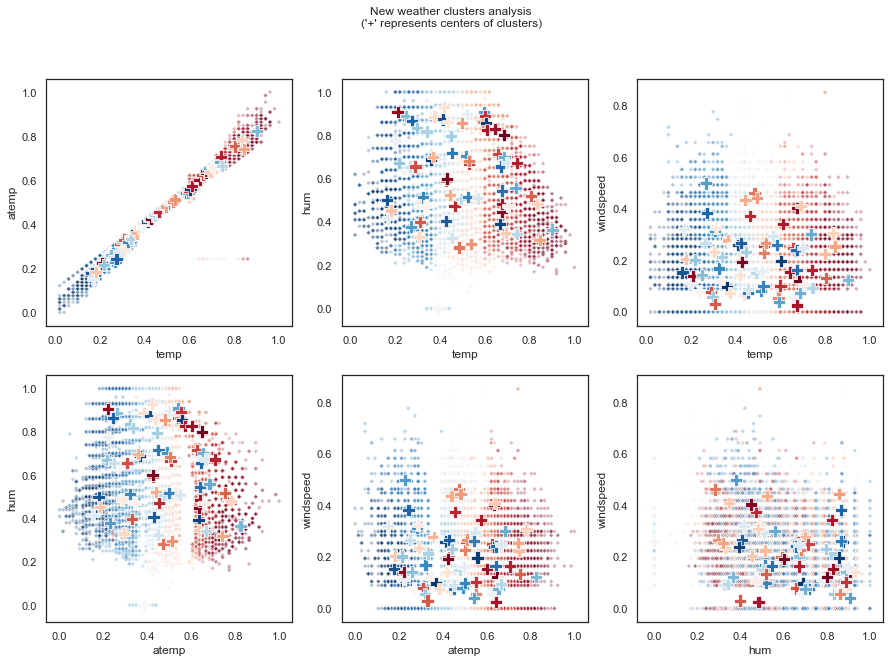

In [40]:
c = sns.color_palette("RdBu_r", n_clusters)

fig,axs = plt.subplots(ncols = 3, nrows = 2, figsize = (15,10))

centers = pd.DataFrame(km.cluster_centers_, columns = weather_continuous_cols + ['weathersit']).sort_values(by = "temp")

for i in range(len(weather_cols_comb)):
    sns.scatterplot(data = df_clustering,
                    x = weather_cols_comb[i][0],
                    y = weather_cols_comb[i][1],
                    hue = "new_wthr_lbl_ordered_temp",
                    alpha = 0.3,
                    ax = axs.flatten()[i],
                    palette = c,
                    marker = "D",
                    s = 10,
                    legend = False)
    sns.scatterplot(data = centers,
                    x = weather_cols_comb[i][0],
                    y = weather_cols_comb[i][1],
                    hue = centers.index,
                    ax = axs.flatten()[i],
                    palette = c,
                    legend = False,
                    marker = "P",
                    s = 150)
plt.suptitle("New weather clusters analysis\n('+' represents centers of clusters)")
plt.show()

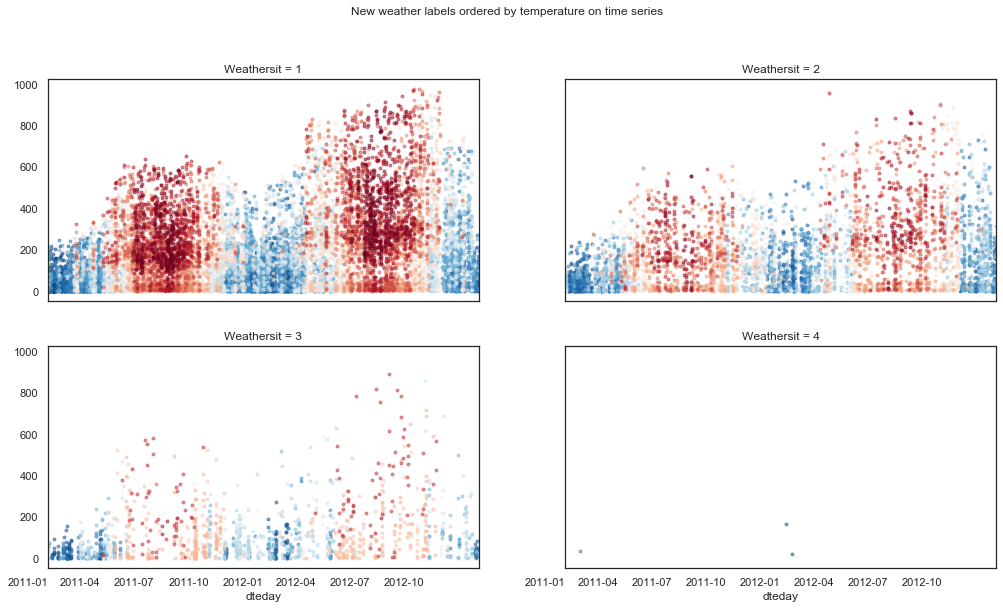

In [41]:
#to simplify, we will create a table with cnt field of new labels in separate columns
k1 = df_clustering.pivot_table(values = 'cnt', columns = "new_wthr_lbl_ordered_temp", index = df_clustering.index)

fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (17,10), sharey = True, sharex = True)
for i in range(1,5):
    k1[df1['weathersit'] == i].plot(marker = ".",
                                    linestyle = "None",
                                    alpha = 0.5,
                                    ax = axs.flatten()[i-1],
                                    color = c,
                                    legend = False,
                                    rot = 0)
    axs.flatten()[i-1].set_title('Weathersit = {}'.format(i))
axs.flatten()[0].set_xlim((k1.index.min(),k1.index.max()))
plt.suptitle("New weather labels ordered by temperature on time series")
plt.show()

The clusters seem to do a good job in separating some of the features of the dataset. Let's order them by mean rentals now.

In [42]:
new_lbl_sort_cnt = df_clustering.groupby("new_wthr_lbl_ordered_temp").cnt.mean().sort_values().reset_index()["new_wthr_lbl_ordered_temp"].astype(int)
new_lbl_sort_cnt = new_lbl_sort_cnt.reset_index()
new_lbl_sort_cnt = new_lbl_sort_cnt.set_index(new_lbl_sort_cnt['new_wthr_lbl_ordered_temp']).iloc[:,0].rename('new_wthr_lbl_ordered_cnt')
new_lbl_sort_cnt.sort_index()
df_clustering = df_clustering.merge(new_lbl_sort_cnt,left_on = 'new_wthr_lbl_ordered_temp', right_index = True)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


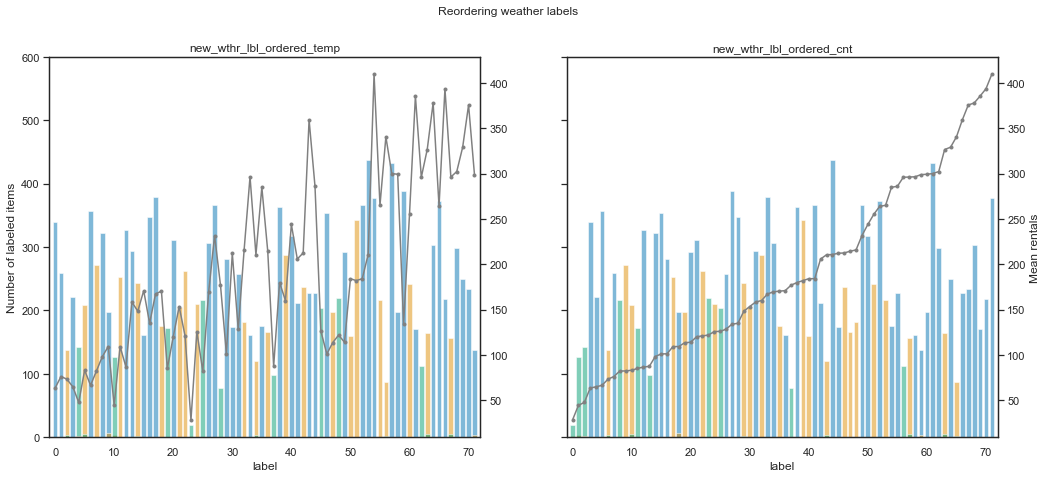

In [43]:
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (17,7), sharex = True, sharey = True)

labels = ["new_wthr_lbl_ordered_temp", "new_wthr_lbl_ordered_cnt"]

for j in range(2):
    for i in range(1,5):
        df_index_test = ((df1['weathersit'] == i))
        df_test = df_clustering[df_index_test][labels[j]].value_counts()
        ax[j].bar(df_test.index, df_test,
                  color = sns.color_palette("colorblind", 4)[i-1],
                  alpha = 0.5)
    ax2 = ax[j].twinx()
    df_clustering.groupby(labels[j]).cnt.mean().plot(marker = ".",
                                                     ax = ax2,
                                                     color = 'grey')
    ax[j].set_ylim((0,600))
    ax[j].set_title(labels[j])
    ax[j].set_xlabel('label')
ax[0].set_ylabel('Number of labeled items')
ax2.set_ylabel('Mean rentals')
plt.suptitle('Reordering weather labels')
ax[0].set_xlim((-1, n_clusters))
plt.show()

Splitting the data that way reveals the change of demand for bike rentals versus the weathersit and the label number increases with the increase of mean rentals almost linearly. We'll keep this labeling. Let's plot it on the timeline now.

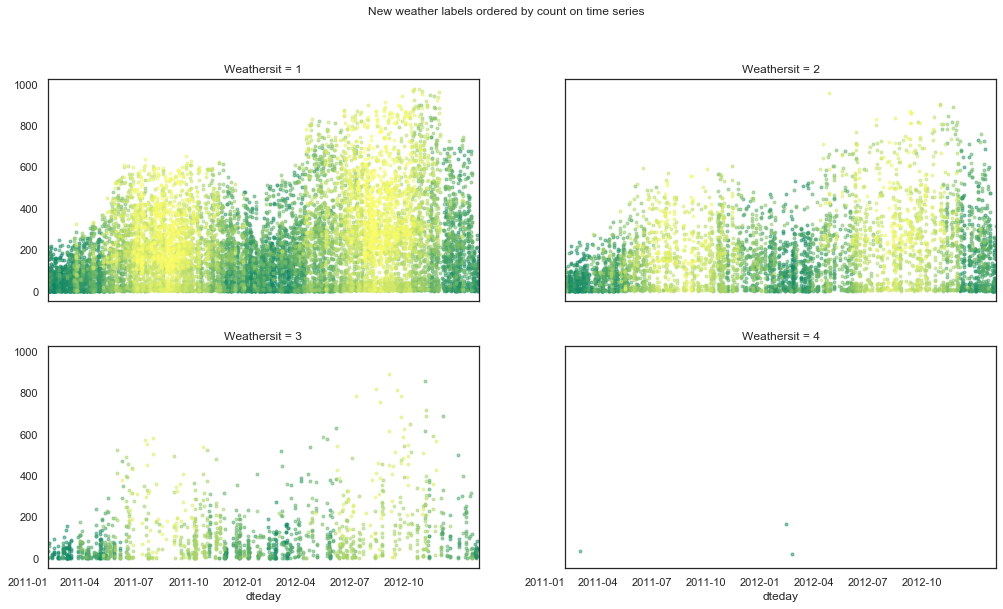

In [44]:
c2 = sns.color_palette("summer", n_clusters)
k2 = df_clustering.pivot_table(values = 'cnt', columns = "new_wthr_lbl_ordered_cnt", index = df_clustering.index)

fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (17,10), sharey = True, sharex = True)
for i in range(1,5):
    k1[df1['weathersit'] == i].plot(marker = ".",
                                    linestyle = "None",
                                    alpha = 0.5,
                                    ax = axs.flatten()[i-1],
                                    color = c2,
                                    legend = False,
                                    rot = 0)
    axs.flatten()[i-1].set_title('Weathersit = {}'.format(i))
axs.flatten()[0].set_xlim((k1.index.min(),k1.index.max()))
plt.suptitle("New weather labels ordered by count on time series")
plt.show()

On the above plot we se that the new labels capture not only the weather situation, but also the mean number of rentals in the cluster. Once again, this reordering should be done in a regression model on a trend-corrected rentals of a train set. But we'll assume that the results would not change significantly for simplification. 

## Adding created labels to a single dataset and studying the correlations

Now, we will append all the extra features we created and prepare the dataset for testing machine learning techniques.

In [45]:
# adding anomaly label
anomaly_dates = filtered.dteday.dt.date
anomaly_dates_index = df1[pd.Series(df1.index.date, index = df1.index).isin(anomaly_dates)].index
df1['anomaly'] = 0
df1.loc[anomaly_dates_index, 'anomaly'] = 1

# adding weather label
df1['weather_lbl'] = df_clustering["new_wthr_lbl_ordered_cnt"].astype(int)

# converting daytime label to category
df1['daytime_lbl'] = df1['daytime_lbl'].astype("category")

Let's create dummy variables for weathersit, as we discussed above. We will also drop weathersit = 1 - we'll think of it as a default weather situation.

In [46]:
df2 = pd.get_dummies(df1, columns = ['weathersit'], drop_first = True, prefix = 'weathersit')

As the daytime_lbl is ordinal, but with different periods, we should split it to dummies as well.

In [47]:
df2 = pd.get_dummies(df2, columns = ['daytime_lbl'], drop_first = True, prefix = 'daytime_lbl')

In [48]:
calendar_cols = ['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', "daytime_lbl_[12:16)", "daytime_lbl_[16:20)",
                 "daytime_lbl_[20:23]", "daytime_lbl_[6:9)", "daytime_lbl_[9:12)"]
weather_cols = ['temp', 'atemp', 'hum', 'windspeed', "weather_lbl", 'weathersit_2','weathersit_3','weathersit_4']
drop = ['anomaly']
target_col = "cnt"

columns_sorted = calendar_cols + weather_cols + drop + [target_col]
dteday = df2.index
df_for_regression = df2[columns_sorted].reset_index(drop = True)

Let's study correlations of variables in the dataset:

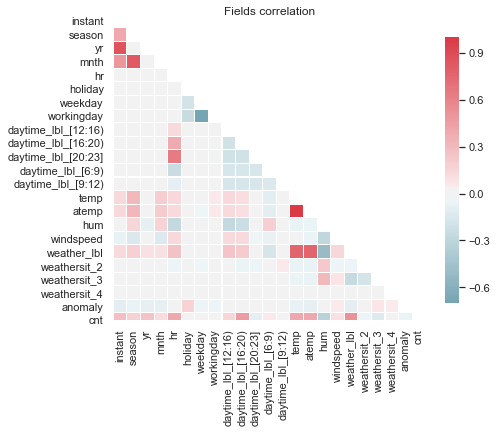

correlation of bike rentals (cnt field) with other fields
cnt                    1.000000
weather_lbl            0.520991
daytime_lbl_[16:20)    0.465814
temp                   0.404772
atemp                  0.400929
hr                     0.394071
instant                0.278295
yr                     0.250495
season                 0.178056
daytime_lbl_[12:16)    0.149307
mnth                   0.120638
windspeed              0.093234
daytime_lbl_[6:9)      0.055049
workingday             0.030284
daytime_lbl_[9:12)     0.022787
weekday               -0.006338
weathersit_4          -0.008340
holiday               -0.030927
weathersit_2          -0.046902
anomaly               -0.056726
daytime_lbl_[20:23]   -0.086783
weathersit_3          -0.128034
hum                   -0.322911
Name: cnt, dtype: float64


In [49]:
corr = df_for_regression.corr()
f, ax = plt.subplots(figsize=(7,7))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .7}, ax = ax)
ax.set_title("Fields correlation")
plt.show()
print("correlation of bike rentals (cnt field) with other fields")
print(corr[target_col].sort_values(ascending = False))

In [50]:
#dropping anomalies
df_for_regression = df_for_regression.drop(df_for_regression.loc[(df_for_regression['anomaly'] == 1)].index).drop(drop, axis = 1)


In [51]:
#resetting index for lin reg to work
df_for_regression = df_for_regression.reset_index(drop = True)

From correlation coefficients we can see that weather label has the highest effect on cnt now.

With this we should finish our data analysis and preparation excersise and move on to the final part - testing prediction models.


## Regression models test

In this last excercise, we will test 3 ML regression methods: Linear Model, Decision Tree and Random Forest. As an error metric we'll use rmse because it works well with continuous numeric data. We will use k fold cross validation technique for estimating performance of the models. Let's initialize it below.

In [52]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=5, random_state = 0)

target = target_col
feats = df_for_regression.columns.drop(target).tolist()
len(feats)

# train = df.sample(frac = 0.8, random_state = 1)
# test = df[~df.index.isin(train.index)]


21

### Linear regression

As the first step, we will use all features as predictors and calculate the error. Next, we'll study if new features, which we created, actually provide an increase of accuracy of predictions. In the end, we'll find the best feats combination for linear regression.

Let's start!

In [53]:
# linear regression
lr_rmses = []
for train_index, test_index in kf.split(df_for_regression):
    train_x = df_for_regression.reindex(index = train_index, columns = feats)
    train_y = df_for_regression.reindex(index = train_index, columns = [target])
    test_x = df_for_regression.reindex(index = test_index, columns = feats)
    test_y = df_for_regression.reindex(index = test_index, columns = [target])

    lr = LinearRegression()
    lr.fit(train_x,train_y)
    lr_prediction = lr.predict(test_x)

    lr_rmses.append(np.sqrt(mean_squared_error(test_y, lr_prediction)))
lr_rmse = np.mean(lr_rmses)
print(lr_rmses)
print(lr_rmse)

[97.0714707237198, 98.2486348215469, 99.90016532862253, 144.9363774995737, 148.30570123000697]
117.692469920694


The model fed with all the feats has rmse 117.7. Let's check if it is better than the simple guess

In [54]:
null_prediction_rmses = []
for train_index, test_index in kf.split(df_for_regression):
    train_y = df_for_regression.reindex(index = train_index, columns = [target])
    test_y = df_for_regression.reindex(index = test_index, columns = [target])
    null_prediction_rmses.append(np.sqrt(mean_squared_error(test_y, [train_y.mean() for i in range(len(test_y))])))
null_prediction_rmse = np.mean(null_prediction_rmses)
print(null_prediction_rmses)
print(null_prediction_rmse)

[150.25064607777605, 149.66713258042384, 144.39116589195095, 235.00855997022813, 232.3156094374743]
182.32662279157066


Linar model produced rmse 117.9, whereas null prediction - 182.3. This is a significant improvement.

### Tweaking linear model

Let's see how we could improve the model. There are several ways how to do this: engineering new feats, decreasing dimensions by selecting fewer and more meaningful predictors, or increasing by turning some ordinal variables to dummy. Or we can use math methods for pulling different trends and then combining their approximations (e.x. log of product gives sum, log of power gives product, etc). Let's spend some time on studying how basic manipulations improve the result.

1. Selecting less features

if there are some fields, without which the prediction would be even more accurate. For this, we'll create combinations of features of different sizes. As the number of columns is relatively high, we will limit ourselves by not reducing the number of feats below 18.

In [55]:
comb = []
for j in range(18, len(feats)+1):
    comb += [list(i) for i in list(combinations(feats,j))]
len(comb)

1562

We will check linear model performance for 1562 combinations of features. That's a lot. Let's track how much time it will take.

In [56]:
rmse_df = pd.DataFrame(index = [str(i) for i in comb], columns = ["LR"])
start_time = time.time()
for feat_comb in comb:
    lr_rmses = []
    for train_index, test_index in kf.split(df_for_regression):
        
        train_x = df_for_regression.reindex(index = train_index, columns = feat_comb)
        train_y = df_for_regression.reindex(index = train_index, columns = [target])
        test_x = df_for_regression.reindex(index = test_index, columns = feat_comb)
        test_y = df_for_regression.reindex(index = test_index, columns = [target])

        lr = LinearRegression()
        lr.fit(train_x,train_y)
        lr_prediction = lr.predict(test_x)

        lr_rmses.append(np.sqrt(mean_squared_error(test_y, lr_prediction)))
    lr_rmse = np.mean(lr_rmses)
    rmse_df.loc[str(feat_comb), "LR"] = lr_rmse
print("--- {:.2f} seconds ---".format(time.time() - start_time))

--- 209.34 seconds ---


In [57]:
rmse_df["LR"].sort_values().head(1)

['season', 'yr', 'hr', 'holiday', 'weekday', 'workingday', 'daytime_lbl_[12:16)', 'daytime_lbl_[16:20)', 'daytime_lbl_[20:23]', 'daytime_lbl_[6:9)', 'daytime_lbl_[9:12)', 'temp', 'atemp', 'windspeed', 'weather_lbl', 'weathersit_2', 'weathersit_3', 'weathersit_4']    117.178
Name: LR, dtype: object

In [58]:
import ast
list(set(feats) - set(ast.literal_eval(rmse_df["LR"].sort_values().index[0])))

['instant', 'mnth', 'hum']

Elimination of month, hum and instant variables resulted in reduction of rmse to 117.2 (-0.6 vs model with all features). Hum and month parameters are indeed already well captured in weather_lbl, and instant we kept for a later excercise - it will help us with extraction of trend. Absense of the month predictor also makes sense in a way that with increase of the month number, the bike rentals change non linearly. This is also true for other daytime parameters that hold seasonality. In order for linear model to work better with them, they should either be sorted by increase of the mean rentals on the train stage, or we could find the seasonality coefficients and apply them to the trendline. Another possible solution might be creation of dummy variables out of them. Let's see how this works next.

2. Converting ordinals to dummy

Let's check the performance of linear model with dummy variables for all datetime features. We will need to remove our daytime labels now, because it will be excessive with dummy hour variables.

In [59]:
#we'll convert all datetime variables that hide seasonality to dummies
vars_seasonality = ['season', 'mnth', 'weekday','hr']
df_for_regression_dummies = pd.get_dummies(df_for_regression, columns = vars_seasonality,
               drop_first = True, prefix = vars_seasonality)
#we dont need daytime labels now
df_for_regression_dummies = df_for_regression_dummies.drop(['daytime_lbl_[12:16)', 'daytime_lbl_[16:20)', 'daytime_lbl_[20:23]', 'daytime_lbl_[6:9)', 'daytime_lbl_[9:12)'], axis = 1)
feats1 = df_for_regression_dummies.columns.drop(target)

In [60]:
lr_rmses = []
for train_index, test_index in kf.split(df_for_regression_dummies):
    train_x = df_for_regression_dummies.reindex(train_index)[feats1]
    train_y = df_for_regression_dummies.reindex(train_index)[target]
    test_x = df_for_regression_dummies.reindex(test_index)[feats1]
    test_y = df_for_regression_dummies.reindex(test_index)[target]

    lr = LinearRegression()
    lr.fit(train_x,train_y)
    lr_prediction = lr.predict(test_x)

    lr_rmses.append(np.sqrt(mean_squared_error(test_y, lr_prediction)))
lr_rmse = np.mean(lr_rmses)
print(lr_rmses)
print(lr_rmse)

[94.89915510905153, 84.14093933275763, 90.72406209266053, 127.43571814181945, 132.02017078343286]
105.8440090919444


We see the improvement of accuracy from rmse 117 to 106. This is an improvement indeed. The only problem here is that it might make our model less smooth if we create too much dummies, and the time of calculations will be longer as well.

3. Linearizing the function

If the function is more complex than linear, we can decompose it by different methonds. Here, for example, one of the basic improvements that we could make would be calculating the general trend by linear regression, then normalizing the values to it and using the linear regression once again. In the end we will need to reverce the steps. Let's see how it could help.

In [61]:
lr_rmses1 = []
for train_index, test_index in kf.split(df_for_regression_dummies):
    
    #splitting to train and test
    train_x = df_for_regression_dummies.reindex(train_index)[feats1]
    test_x = df_for_regression_dummies.reindex(test_index)[feats1]
    train_y = df_for_regression_dummies.reindex(train_index)[target]
    test_y = df_for_regression_dummies.reindex(test_index)[target]

    #pulling the trend
    lr = LinearRegression()
    lr.fit(train_x['instant'].values.reshape(-1,1),train_y)
    
    linear_approx_s1 = lr.predict(train_x['instant'].values.reshape(-1,1))
    linear_approx_s2 = lr.predict(test_x['instant'].values.reshape(-1,1))

    
    #pulling trend-corrected prediction
    train_x1 = train_x[list(set(feats1) - set('instant'))]
    test_x1 = test_x[list(set(feats1) - set('instant'))]
    train_y1 = train_y / linear_approx_s1
    test_y1 = test_y / linear_approx_s2

    lr1 = LinearRegression()
    lr1.fit(train_x1,train_y1)
    
    trend_corrected_approx_s1 = lr1.predict(train_x1)
    trend_corrected_approx_s2 = lr1.predict(test_x1)
    
    #combining the predictions
    total_approx_s2 = linear_approx_s2 * trend_corrected_approx_s2
    
    #calculating rmses
    rmse = np.sqrt(mean_squared_error(test_y, total_approx_s2))
    lr_rmses1.append(rmse)

lr_rmse1 = np.mean(lr_rmses1)
print(lr_rmses1)
print(lr_rmse1)

[66.91205095878951, 86.64111700641817, 86.74603118308237, 122.13843461139301, 126.96343770592401]
97.88021429312141


The error decreased from 106 to 98. We can make the model more and more accurate by this technique. But let's move forwards and check how other regression models tackle this problem.


## Decision tree model

Let's see if decision tree model would peform better.


In [62]:
#we have done several manipulations with df, and now it is not in best shape for decision tree
#let's recompile it
df_for_trees = df_for_regression.merge(df1[['weathersit','daytime_lbl']], left_index = True, right_on = df1.reset_index().index, how = 'inner')
df_for_trees = df_for_trees.drop(['daytime_lbl_[12:16)', 'daytime_lbl_[16:20)', 'daytime_lbl_[20:23]', 'daytime_lbl_[6:9)', 'daytime_lbl_[9:12)'], axis = 1)
df_for_trees = df_for_trees.drop(['key_0','weathersit_2', 'weathersit_3', 'weathersit_4'], axis = 1)
df_for_trees = df_for_trees.reset_index(drop = True)
df_for_trees['daytime_lbl'] = df_for_trees['daytime_lbl'].cat.codes
feats_dt = df_for_trees.columns.drop(target)

In [63]:
dt_rmses_train = []
dt_rmses_test = []
for train_index, test_index in kf.split(df_for_trees):
    train_x = df_for_trees.reindex(train_index)[feats_dt]
    train_y = df_for_trees.reindex(train_index)[target]
    test_x = df_for_trees.reindex(test_index)[feats_dt]
    test_y = df_for_trees.reindex(test_index)[target]

    dt = DecisionTreeRegressor(random_state = 0)
    dt.fit(train_x,train_y)
    dt_prediction_train = dt.predict(train_x)
    dt_prediction_test = dt.predict(test_x)

    dt_rmses_train.append(np.sqrt(mean_squared_error(train_y, dt_prediction_train)))
    dt_rmses_test.append(np.sqrt(mean_squared_error(test_y, dt_prediction_test)))
    
dt_rmse_train = np.mean(dt_rmses_train)
dt_rmse_test = np.mean(dt_rmses_test)

print('Train error:')
print(dt_rmses_train)
print(dt_rmse_train)
print()
print('Test error:')
print(dt_rmses_test)
print(dt_rmse_test)

Train error:
[0.0, 0.0, 0.0, 0.0, 0.0]
0.0

Test error:
[89.28892858819151, 63.50551682681207, 102.15534612407488, 80.91306606483039, 110.9591696013912]
89.36440544106


From the above we see that the model performes slightly better - rmse is around 89 vs 98 in our 'best' linear regression model. However, it is significancly overfitted: rmse for the training set prediction is 0 whereas for test set it is not. We should generalize the model a bit: let's test different model parameters.

### Decision tree model optimization

We will optimize the model in several ways: by finding the optimal parameters and by combining it with linear regression.

1. Finding optimal parameters for a simple decision tree

We will test varying min samples split and min samples leaf parameters of the model in order to generalize it. What we are looking for is the minimal difference between rmses for test and train sets' predictions. 

In [64]:
lf = np.arange(1,51, 5)
spl = np.arange(2,51, 5)

spl_lf_df = pd.DataFrame(columns = lf, index = spl)

start_time = time.time()
for i in spl:
    for j in lf:
        dt_rmses_train = []
        dt_rmses_test = []
        for train_index, test_index in kf.split(df_for_trees):
            train_x = df_for_trees.reindex(train_index)[feats_dt]
            train_y = df_for_trees.reindex(train_index)[target]
            test_x = df_for_trees.reindex(test_index)[feats_dt]
            test_y = df_for_trees.reindex(test_index)[target]

            dt = DecisionTreeRegressor(min_samples_split = i,
                                       min_samples_leaf = j, random_state = 0)
            dt.fit(train_x,train_y)
            dt_prediction_train = dt.predict(train_x)
            dt_prediction_test = dt.predict(test_x)

            dt_rmses_train.append(np.sqrt(mean_squared_error(train_y, dt_prediction_train)))
            dt_rmses_test.append(np.sqrt(mean_squared_error(test_y, dt_prediction_test)))

        dt_rmse_train = np.mean(dt_rmses_train)
        dt_rmse_test = np.mean(dt_rmses_test)
        spl_lf_df.loc[i,j] = (round(dt_rmse_test,2),round(dt_rmse_train,2))
print("--- {:.2f} seconds ---".format(time.time() - start_time))

--- 51.70 seconds ---


In [65]:
spl_lf = spl_lf_df.reset_index().melt(id_vars = "index")
spl_lf = pd.concat([spl_lf,pd.DataFrame(spl_lf['value'].tolist(), index=spl_lf.index)], axis = 1)
spl_lf = spl_lf.drop("value", axis = 1)
spl_lf.columns = ["min_samples_split", "min_samples_leaf", "rmse_test","rmse_train"]
spl_lf ["abs_diff"] = (spl_lf["rmse_test"] - spl_lf["rmse_train"]).abs()

In [66]:
print('Optimal parameters (top 3):')
print(spl_lf.sort_values(by = ["abs_diff","rmse_test",
                               "min_samples_leaf","min_samples_split"]).head(3))
print()
print('Lowest rmse for test set parameters (top 3):')
print(spl_lf.sort_values(by = ["rmse_test","min_samples_leaf","min_samples_split"]).head(3))

Optimal parameters (top 3):
    min_samples_split min_samples_leaf  rmse_test  rmse_train  abs_diff
80                  2               41      83.77       54.85     28.92
81                  7               41      83.77       54.85     28.92
82                 12               41      83.77       54.85     28.92

Lowest rmse for test set parameters (top 3):
    min_samples_split min_samples_leaf  rmse_test  rmse_train  abs_diff
37                 37               16      78.71       45.51     33.20
38                 42               16      78.79       46.19     32.60
30                  2               16      78.87       44.89     33.98


It looks like the model is more or less well generalized with min_samples_leaf = 41. And the best result in predicting test sets was obtained with min_samples_split = 37 and min_samples_leaf = 16.
Overall, the optimization of the model parameters allowed us to decrease rmse from 91 to around 80.

2. Combination with linear regression

Let's repeate the last excercise of the linear model's optimization: we'll find the trend first with linear regression, and then use decision tree to predict the rest. We'll do 2 iterations with standard parameters of decision tree and then we'll try to optimize the model.

In [67]:
def combined_lin_dt(spl = 2, lf = 1):
    dt_rmses_train = []
    dt_rmses_test = []
    for train_index, test_index in kf.split(df_for_regression_dummies):

        #splitting to train and test
        train_x = df_for_regression_dummies.reindex(train_index)[feats1]
        test_x = df_for_regression_dummies.reindex(test_index)[feats1]
        train_y = df_for_regression_dummies.reindex(train_index)[target]
        test_y = df_for_regression_dummies.reindex(test_index)[target]

        #pulling the trend
        lr = LinearRegression()
        lr.fit(train_x['instant'].values.reshape(-1,1),train_y)

        linear_approx_s1 = lr.predict(train_x['instant'].values.reshape(-1,1))
        linear_approx_s2 = lr.predict(test_x['instant'].values.reshape(-1,1))


        #pulling trend-corrected prediction
        train_x1 = train_x[list(set(feats1) - set('instant'))]
        test_x1 = test_x[list(set(feats1) - set('instant'))]
        train_y1 = train_y / linear_approx_s1
        test_y1 = test_y / linear_approx_s2

        dt = DecisionTreeRegressor(min_samples_split = spl,
                                   min_samples_leaf = lf,
                                   random_state = 0)
        dt.fit(train_x1,train_y1)
        trend_corrected_approx_s1 = dt.predict(train_x1)
        trend_corrected_approx_s2 = dt.predict(test_x1)

        #combining the predictions
        total_approx_s1 = linear_approx_s1 * trend_corrected_approx_s1
        total_approx_s2 = linear_approx_s2 * trend_corrected_approx_s2


        #calculating rmses
        dt_rmses_train.append(np.sqrt(mean_squared_error(train_y, total_approx_s1)))
        dt_rmses_test.append(np.sqrt(mean_squared_error(test_y, total_approx_s2)))
    return(dt_rmses_train,dt_rmses_test)

In [68]:
dt_rmses_train,dt_rmses_test = combined_lin_dt(spl = 2, lf = 1)
dt_rmse_train = np.mean(dt_rmses_train)
dt_rmse_test = np.mean(dt_rmses_test)
print('Train error:')
print(dt_rmses_train)
print(dt_rmse_train)
print()
print('Test error:')
print(dt_rmses_test)
print(dt_rmse_test)

Train error:
[0.007281670085599119, 0.00713611280535231, 0.0075198843642362845, 0.006539115573871734, 0.006515620355340964]
0.006998480636880082

Test error:
[63.67279074605407, 70.0708623309614, 74.56149062571076, 86.75784409913648, 110.03189783555091]
81.01897712748273


That's actually a good result, because we managed to predict test with error at around 80 once again. This was expected as the model is not built to capture trend as good as linear regression.

3. Finding optimal parameters for combined model

Now, let's finish with optimization of the model by selecting the optimal parameters.

In [69]:
lf1 = np.arange(1,51,10)
spl1 = np.arange(2,51,10)

spl_lf_df1 = pd.DataFrame(columns = lf1, index = spl1)

start_time = time.time()
for i in spl1:
    for j in lf1:
        dt_rmses_train = []
        dt_rmses_test = []
        for train_index, test_index in kf.split(df_for_trees):
            rmses_train, rmses_test = combined_lin_dt(spl = i, lf = j)
            dt_rmses_train.append(np.mean(rmses_train))
            dt_rmses_test.append(np.mean(rmses_test))

        dt_rmse_train = np.mean(dt_rmses_train)
        dt_rmse_test = np.mean(dt_rmses_test)
        spl_lf_df1.loc[i,j] = (round(dt_rmse_test,2),round(dt_rmse_train,2))
print("--- {:.2f} seconds ---".format(time.time() - start_time))

--- 155.30 seconds ---


In [70]:
spl_lf1 = spl_lf_df1.reset_index().melt(id_vars = "index")
spl_lf1 = pd.concat([spl_lf1,pd.DataFrame(spl_lf1['value'].tolist(), index=spl_lf1.index)], axis = 1)
spl_lf1 = spl_lf1.drop("value", axis = 1)
spl_lf1.columns = ["min_samples_split", "min_samples_leaf", "rmse_test","rmse_train"]
spl_lf1 ["abs_diff"] = (spl_lf1["rmse_test"] - spl_lf1["rmse_train"]).abs()
print('Optimal parameters (top 3):')
print(spl_lf1.sort_values(by = ["abs_diff","rmse_test",
                               "min_samples_leaf","min_samples_split"]).head(3))
print()
print('Lowest rmse for test set parameters (top 3):')
print(spl_lf1.sort_values(by = ["rmse_test","min_samples_leaf","min_samples_split"]).head(3))

Optimal parameters (top 3):
    min_samples_split min_samples_leaf  rmse_test  rmse_train  abs_diff
20                  2               41      78.79       67.77     11.02
21                 12               41      78.79       67.77     11.02
22                 22               41      78.79       67.77     11.02

Lowest rmse for test set parameters (top 3):
   min_samples_split min_samples_leaf  rmse_test  rmse_train  abs_diff
4                 42                1      70.86       48.81     22.05
8                 32               11      71.44       51.62     19.82
9                 42               11      71.90       53.82     18.08


From the numbers we see that not only the error became less, but it is much more generalized as well: the lowest error in this model has rmse 70 and difference with train rmse 22, whereas the most accurate model without using linear regression first produced the best result with test rmse 79 and diference 33.

Let's try random forest model next.


## Random forest model

Let's finish the project with reiteration of the previous analysis - now with random forest model. The model should be better generalized vs decision tree, and the accuracy should be even higher. It is interesting to see how better it can be than the previous ones.

Like before, we will look at basic performance, and then we will try to optimize it.

In [71]:
rf_rmses_train = []
rf_rmses_test = []
for train_index, test_index in kf.split(df_for_trees):
    train_x = df_for_trees.reindex(train_index)[feats_dt]
    train_y = df_for_trees.reindex(train_index)[target]
    test_x = df_for_trees.reindex(test_index)[feats_dt]
    test_y = df_for_trees.reindex(test_index)[target]

    rf = RandomForestRegressor(n_estimators = 10, random_state = 0)
    rf.fit(train_x,train_y)
    rf_prediction_train = rf.predict(train_x)
    rf_prediction_test = rf.predict(test_x)

    rf_rmses_train.append(np.sqrt(mean_squared_error(train_y, rf_prediction_train)))
    rf_rmses_test.append(np.sqrt(mean_squared_error(test_y, rf_prediction_test)))
    
rf_rmse_train = np.mean(rf_rmses_train)
rf_rmse_test = np.mean(rf_rmses_test)

print('Train error:')
print(rf_rmses_train)
print(rf_rmse_train)
print()
print('Test error:')
print(rf_rmses_test)
print(rf_rmse_test)

Train error:
[20.009251505772074, 19.225059217470935, 19.359829896954203, 18.749764285614518, 17.031654514862584]
18.875111884134864

Test error:
[74.93354631872279, 52.60312705176292, 73.01614139117743, 67.5193513672486, 85.68580114407335]
70.75159345459703


The results are very close to the best that was obtained in previous model. We see that the model is well generalized already. Let's not spend much time on finding the optimal parameters as it will take too long already. Instead, we'll check how the error changes if we increase the min_samples_leaf parameter to 10.

In [72]:
rf_rmse_train_plot = []
rf_rmse_test_plot = []

lf = range(1,11)

for i in lf:
    rf_rmses_train = []
    rf_rmses_test = []
    for train_index, test_index in kf.split(df_for_trees):
        train_x = df_for_trees.reindex(train_index)[feats_dt]
        train_y = df_for_trees.reindex(train_index)[target]
        test_x = df_for_trees.reindex(test_index)[feats_dt]
        test_y = df_for_trees.reindex(test_index)[target]

        rf = RandomForestRegressor(n_estimators = 10, random_state = 0, min_samples_leaf = i)
        rf.fit(train_x,train_y)
        rf_prediction_train = rf.predict(train_x)
        rf_prediction_test = rf.predict(test_x)

        rf_rmses_train.append(np.sqrt(mean_squared_error(train_y, rf_prediction_train)))
        rf_rmses_test.append(np.sqrt(mean_squared_error(test_y, rf_prediction_test)))

    rf_rmse_train = np.mean(rf_rmses_train)
    rf_rmse_test = np.mean(rf_rmses_test)
    
    rf_rmse_train_plot.append(rf_rmse_train)
    rf_rmse_test_plot.append(rf_rmse_test)

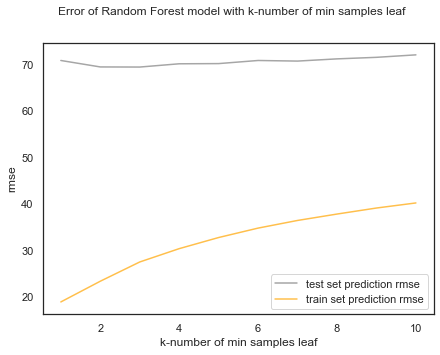

In [73]:
fig, ax = plt.subplots(figsize = (7,5))
ax.plot(lf, rf_rmse_test_plot, color = 'grey', alpha = 0.7, label = 'test set prediction rmse')
ax.plot(lf, rf_rmse_train_plot, color = 'orange', alpha = 0.7, label = 'train set prediction rmse')
plt.suptitle('Error of Random Forest model with k-number of min samples leaf')
ax.set_xlabel('k-number of min samples leaf')
ax.set_ylabel('rmse')
ax.legend()
plt.show()

In [74]:
min(rf_rmse_test_plot)

69.33987337806784

From the above chart we see that the model's error is minimal at 69.3 with number of min samples = 2. Then it starts increasing with the increase of the number of min samples in a leaf. The error of train set increases gradually.

Let's test the combined model now.

In [75]:
def combined_lin_rf(spl = 2, lf = 1):
    rf_rmses_train = []
    rf_rmses_test = []
    for train_index, test_index in kf.split(df_for_regression_dummies):

        #splitting to train and test
        train_x = df_for_regression_dummies.reindex(train_index)[feats1]
        test_x = df_for_regression_dummies.reindex(test_index)[feats1]
        train_y = df_for_regression_dummies.reindex(train_index)[target]
        test_y = df_for_regression_dummies.reindex(test_index)[target]

        #pulling the trend
        lr = LinearRegression()
        lr.fit(train_x['instant'].values.reshape(-1,1),train_y)

        linear_approx_s1 = lr.predict(train_x['instant'].values.reshape(-1,1))
        linear_approx_s2 = lr.predict(test_x['instant'].values.reshape(-1,1))


        #pulling trend-corrected prediction
        train_x1 = train_x[list(set(feats1) - set('instant'))]
        test_x1 = test_x[list(set(feats1) - set('instant'))]
        train_y1 = train_y / linear_approx_s1
        test_y1 = test_y / linear_approx_s2
        
        rf = RandomForestRegressor(n_estimators = 10,
                                   min_samples_split = spl,
                                   min_samples_leaf = lf,
                                   random_state = 0)
        
        rf.fit(train_x1,train_y1)
        trend_corrected_approx_s1 = rf.predict(train_x1)
        trend_corrected_approx_s2 = rf.predict(test_x1)

        #combining the predictions
        total_approx_s1 = linear_approx_s1 * trend_corrected_approx_s1
        total_approx_s2 = linear_approx_s2 * trend_corrected_approx_s2


        #calculating rmses
        rf_rmses_train.append(np.sqrt(mean_squared_error(train_y, total_approx_s1)))
        rf_rmses_test.append(np.sqrt(mean_squared_error(test_y, total_approx_s2)))
    return(rf_rmses_train,rf_rmses_test)

In [76]:
combined_lin_rf(spl = 2, lf = 1)

rf_rmses_train,rf_rmses_test = combined_lin_rf(spl = 2, lf = 1)
rf_rmse_train = np.mean(rf_rmses_train)
rf_rmse_test = np.mean(rf_rmses_test)
print('Train error:')
print(rf_rmses_train)
print(rf_rmse_train)
print()
print('Test error:')
print(rf_rmses_test)
print(rf_rmse_test)

Train error:
[22.987748604917343, 23.121107775316915, 21.802628583078775, 21.123498187537773, 20.650023003916054]
21.93700123095337

Test error:
[49.11107479857629, 56.01250476428576, 54.613184012239174, 68.91552233258015, 81.02534176210182]
61.935525533956636


The error indeed decreased  - it is 2 times lower now than at the simplest linear regression's. Let's see how it varies with the change of min leaf splits.

In [77]:
rf_rmse_train_plot = []
rf_rmse_test_plot = []

lf = range(1,11)

for i in lf:
    rf_rmses_train, rf_rmses_test = combined_lin_rf(lf = i)
    
    rf_rmse_train = np.mean(rf_rmses_train)
    rf_rmse_test = np.mean(rf_rmses_test)
    
    rf_rmse_train_plot.append(rf_rmse_train)
    rf_rmse_test_plot.append(rf_rmse_test)

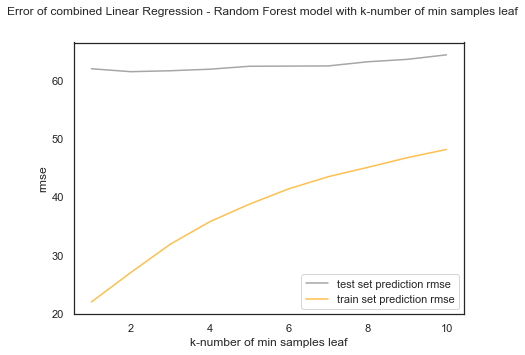

In [78]:
fig, ax = plt.subplots(figsize = (7,5))
ax.plot(lf, rf_rmse_test_plot, color = 'grey', alpha = 0.7, label = 'test set prediction rmse')
ax.plot(lf, rf_rmse_train_plot, color = 'orange', alpha = 0.7, label = 'train set prediction rmse')
plt.suptitle('Error of combined Linear Regression - Random Forest model with k-number of min samples leaf')
ax.set_xlabel('k-number of min samples leaf')
ax.set_ylabel('rmse')
ax.legend()
plt.show()

In [79]:
print('min rmse: {:.2f} at min_samples_leaf = {}'.format(min(rf_rmse_test_plot),
                                                        (rf_rmse_test_plot.index(min(rf_rmse_test_plot)) + 1)))

min rmse: 61.43 at min_samples_leaf = 2


We were able to slightly improve the model's performance. With that, we will finish our excercise of optimization of regression models. Overall, we see that random forest produces better results, but they can be even better if we combine it with other methods in a meaningful way. 

## As a conclusion

In this project we studied the data on hourly bike rentals in Washington D.C. in 2011-2012: cleaned the data set, conducted an exploratory analysis, created some new labels and tried to fit 3 machine learning algorythms to it: linear regression, decision tree and random forest.

Not surprisingly, a combination of a linear and a random forest regresions resulted a much more accurate prediction of demand for hourly bike rentals.

The findings of this study could be a good basis for building more complex prediction models for different purposes.